# Описание проекта

Требуется подготовить прототип модели машинного обучения для заказчика. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В рамках задачи предоставлены даннные по параметрам добычи и очистки. 

Модель будет использована для оптимизации производства, чтобы не запускать предприятие с убыточными характеристиками.

Потребуется в рамках исследования:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


# Описание исходных данных
Данные находятся в трёх файлах:
- gold_recovery_train.csv — обучающая выборка
- gold_recovery_test.csv — тестовая выборка
- gold_recovery_full.csv — исходные данные

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

In [42]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
import numpy as np 
from operator import itemgetter, attrgetter
import pandas as pd
import pandas.plotting
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 1. Подготовка данных  

## 1.1 Изучение файлов

In [43]:
path1 = '/datasets/gold_recovery_train.csv'

gold_recovery_train = pd.read_csv(path1,parse_dates=['date'])
path2 = '/datasets/gold_recovery_test.csv'

gold_recovery_test = pd.read_csv(path2,parse_dates=['date'])
path3 ='/datasets/gold_recovery_full.csv'

gold_recovery_full = pd.read_csv(path3,parse_dates=['date'])

In [44]:
def common_info(data):    
    display(data.info())
    display(data.head(10))
    display(data.tail(10))
    display(data.loc[data.isna().any(axis=1),:])    

In [45]:
common_info(gold_recovery_full)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null datetime64[ns]
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant     

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
22706,2018-08-18 01:59:59,3.236759,11.692898,6.745979,46.225130,73.265872,8.895144,3.425167,10.118103,1.611159,132.723539,8.003791,6.283333,1.148652,6.250206,12.671935,6.968363,33.543341,22.636772,6.610989,4.281521,2.332941,1647.735565,-400.061136,1649.457537,-399.456945,1650.385133,-399.375007,1649.409465,-400.605830,47996.497221,2498.160551,2498.390499,1.125554,5.991053,4.887487,547.273785,82.210677,37.663932,5.501130,7.713332,8.902892,7.713595,8.541827,9.578575,10.321667,27.501761,17.200572,90.732567,4.131306,0.603649,15.991752,0.718232,1201.841545,-299.984514,1149.184639,-499.994347,1048.740007,-500.024919,957.358660,-499.664991,849.596840,-500.389175,850.254354,-500.049111,8.967923,7.093982,NaN,1.615687,34.960260,-501.279042,30.000837,-500.309952,26.005410,-499.896222,23.016695,-499.961916,23.015413,-501.287519,20.057415,-499.600478,17.985857,-500.239983,12.974452,-499.879930,19.988701,-501.037332
22707,2018-08-18 02:59:59,3.187398,11.423128,6.790500,46.801679,68.369674,9.043962,3.629573,10.037518,1.838214,132.726374,8.009750,6.500000,1.230668,5.89963

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,126.397495,12.709727,7.250000,1.229626,8.092185,9.719728,19.077471,38.624404,15.911266,3.269298,7.095597,3.513846,1601.301169,-498.725777,1605.370031,-500.644437,1598.360694,-500.461991,1604.014273,-501.824136,35990.036451,3220.710538,3206.895723,3.168669,7.934791,1.763437,229.379445,40.601032,NaN,5.587750,10.865871,5.648950,10.786929,5.638302,0.000000,0.000000,0.000000,0.000000,0.000000,4.990718,0.901107,19.096033,2.126460,1003.354806,-501.078303,1603.648910,-498.000810,1603.488420,-495.577057,1402.004381,-497.117094,1203.394353,-494.391170,1202.592202,-500.167701,13.648648,5.146849,9.601115,3.108674,26.069763,-502.180953,24.044256,-502.252420,25.024571,-499.417407,23.983086,-499.931140,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,69.411904,7.443190,7.250000,0.926251,7.680496,9.038210,

In [46]:
common_info(gold_recovery_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null datetime64[ns]
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant     

None

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
16850,2018-08-18 01:59:59,3.236759,11.692898,6.745979,46.225130,73.265872,8.895144,3.425167,10.118103,1.611159,132.723539,8.003791,6.283333,1.148652,6.250206,12.671935,6.968363,33.543341,22.636772,6.610989,4.281521,2.332941,1647.735565,-400.061136,1649.457537,-399.456945,1650.385133,-399.375007,1649.409465,-400.605830,47996.497221,2498.160551,2498.390499,1.125554,5.991053,4.887487,547.273785,82.210677,37.663932,5.501130,7.713332,8.902892,7.713595,8.541827,9.578575,10.321667,27.501761,17.200572,90.732567,4.131306,0.603649,15.991752,0.718232,1201.841545,-299.984514,1149.184639,-499.994347,1048.740007,-500.024919,957.358660,-499.664991,849.596840,-500.389175,850.254354,-500.049111,8.967923,7.093982,NaN,1.615687,34.960260,-501.279042,30.000837,-500.309952,26.005410,-499.896222,23.016695,-499.961916,23.015413,-501.287519,20.057415,-499.600478,17.985857,-500.239983,12.974452,-499.879930,19.988701,-501.037332
16851,2018-08-18 02:59:59,3.187398,11.423128,6.790500,46.801679,68.369674,9.043962,3.629573,10.037518,1.838214,132.726374,8.009750,6.500000,1.230668,5.89963

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
47,2016-01-16 23:00:00,4.591462,10.628846,5.688961,46.663335,55.088448,10.694584,1.671644,17.910312,2.686782,126.397495,12.709727,7.250000,1.229626,8.092185,9.719728,19.077471,38.624404,15.911266,3.269298,7.095597,3.513846,1601.301169,-498.725777,1605.370031,-500.644437,1598.360694,-500.461991,1604.014273,-501.824136,35990.036451,3220.710538,3206.895723,3.168669,7.934791,1.763437,229.379445,40.601032,NaN,5.587750,10.865871,5.648950,10.786929,5.638302,0.000000,0.000000,0.000000,0.000000,0.000000,4.990718,0.901107,19.096033,2.126460,1003.354806,-501.078303,1603.648910,-498.000810,1603.488420,-495.577057,1402.004381,-497.117094,1203.394353,-494.391170,1202.592202,-500.167701,13.648648,5.146849,9.601115,3.108674,26.069763,-502.180953,24.044256,-502.252420,25.024571,-499.417407,23.983086,-499.931140,13.997488,-551.224653,11.971272,-550.095619,9.981163,-502.869109,7.941184,-500.623610,12.018837,-600.916665
48,2016-01-17 00:00:00,5.296830,10.597469,NaN,44.015642,41.962008,11.975654,1.846558,8.138408,2.889469,69.411904,7.443190,7.250000,0.926251,7.680496,9.038210,

In [47]:
common_info(gold_recovery_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null datetime64[ns]
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
ro

None

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
5846,2017-12-31 14:59:59,179.404979,16.010885,8.07,0.916931,1398.659799,-500.330322,1402.654581,-500.677428,1400.810827,-499.941977,1399.277447,-499.435793,11.836037,4.929374,508.556165,66.080187,41.357661,11.016597,10.540131,6.728826,10.544150,6.721195,1400.345778,-300.049518,1050.076744,-499.484771,949.547020,-500.397265,850.790097,-499.692441,850.462928,-500.119166,850.845597,-500.377011,22.024165,-500.056743,20.030518,-499.615004,24.979939,-499.499757,13.002074,-499.701253,14.019794,-499.342919,12.012442,-500.006762,8.050740,-499.743588,5.914007,-500.221697,8.972648,-498.345926
5847,2017-12-31 15:59:59,178.225825,15.983132,8.07,0.872683,1400.796488,-495.620245,1403.704300,-474.929431,1405.006957,-508.344669,1400.774137,-495.995174,11.938526,5.030976,508.714860,59.441001,39.989229,10.882578,10.407470,7.034592,10.401898,7.033789,1403.479568,-299.031955,1055.666834,-499.108727,954.868366,-497.505287,852.084935,-499.008323,849.368260,-501.079976,849.801771,-498.002372,25.413091,-492.691979,23.430425,-499.465495,26.551770,-499.305218,18.119180,-499.740292,16.886746,-495.632233,13.422906,-499.106379,9.461047,-497.245439,7.418705,-499.655926,10.384888,-499.907300
5848,2017-12-31 16:59:59,175.659892,16.006896,8.07,0.902511,1479.674899,-508.101587,1480.470306,-520.946138,1457.639776,-491.907626,1478.514256,-502.859390,12.153979,5.145386,508.344430,65.256196,40.812899,11.094590,10.565344,7.201369,10.567578,7.200726,1396.247235,-300.360332,1044.125130,-501.827426,947.961603,-501.016116,858.777292,-501.774426,849.412202,-498.867885,848.840663,-500.872130,27.499881,-503.720416,25.523498,-500.517683,27.454198,-501.769977,20.967987,-500.241865,18.864683,-506.142516,14.490365,-500.750090,10.427824,-503.240854,8.502090,-500.193042,11.411822,-500.893381
5849,2017-12-31 17:59:59,178.574496,16.013747,8.07,0.902684,1401.246101,-495.595252,1401.187864,-504.455211,1401.687845,-500.596508,1399.266430,-500.799235,12.200516,5.063751,504.396153,64.531948,41.533941,10.993759,10.481916,7.199515,10.482314,7.199652,1399.752309,-300.287160,1049.684591,-500.013879,947.140380,-501.229683,839.917565,-500.315122,850

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
30,2016-09-02 06:59:59,NaN,NaN,7.1600,NaN,4.126292e+02,-795.316337,4.137033e+02,-787.396567,4.416043e+02,-799.942901,2.779496e+02,-799.760111,0.568441,0.273677,0.185161,73.863127,3.091118,0.568632,NaN,0.005559,0.002121,0.017055,802.900908,-522.987484,900.542913,-650.245277,1005.732206,-439.919433,1009.700913,-619.995695,676.186135,-649.267537,617.387077,-445.400385,15.220105,-725.426349,6.004391,-788.919901,0.000000e+00,-796.177023,6.203523e+00,-660.374105,6.576244e+00,-616.550019,4.625908e+00,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
31,2016-09-02 07:59:59,5.039223,NaN,7.1600,NaN,1.436850e+03,-542.923353,1.549141e+03,-528.601849,1.548665e+03,-602.372163,1.036774e+03,-628.775109,0.000000,0.000000,0.211620,71.894046,0.000000,0.000000,0.011840,0.012073,0.525355,0.032552,1000.902375,-359.894045,1247.548022,-426.251147,1253.188339,-390.765259,1203.699896,-524.568449,1000.122726,-567.203153,951.854071,-397.397533,24.929108,-509.656217,12.024056,-568.886327,NaN,-511.768142,1.201238e+01,-504.951356,1.193514e+01,-496.491878,7.967571e+00,-527.714564,8.191769,-517.004063,4.906812,-531.125899,10.002271,-527.901468
32,2016-09-02 08:59:59,0.857926,NaN,7.1600,NaN,1.435628e+03,-499.752988,1.550872e+03,-500.348180,1.513760e+03,-500.981729,1.214021e+03,-499.342193,0.000000,0.000000,65.388467,26.203151,0.000000,0.000000,0.007475,0.013619,0.451574,0.053785,1000.145282,-341.428811,1251.260298,-398.123831,1252.757907,-395.927720,1207.509287,-395.892725,1002.172906,-398.376249,951.673520,-397.282485,24.980736,-500.270485,11.965029,-500.006814,NaN,-499.628944,1.197026e+01,-500.304288,1.192112e+01,-500.796461,7.988670e+00,-501.212454,8.067387,-501.622580,5.067141,-499.295523,9.989370,-500.350093
33,2016-09-02 09:59:59,24.616337,0.600245,7.1600,0.196905,1.437686e+03,-498.718550,1.549223e+03,-498.417613,1.510245e+03,-485.720032,1.171750e+03,-503.665793,6.524680,3.242208,398.513476,56.214413,32.361834,6.856136,6.188146,3.276636,5.546038,4.427095,998.610490,-348.708812,1246.603541,-399.451558,1245.059234,-400.364883,1184.722025,-401.299003,999.105073,-398.719957,948.607450,-400.4

<font color='green'>Ок, данные загрузили. </font>


## 1.2. Проверка правильности расчета эффективности обогащения. 

Сперва пишем Recovery функцию согласно заданию:
Эффективность обогащения рассчитывается по формуле
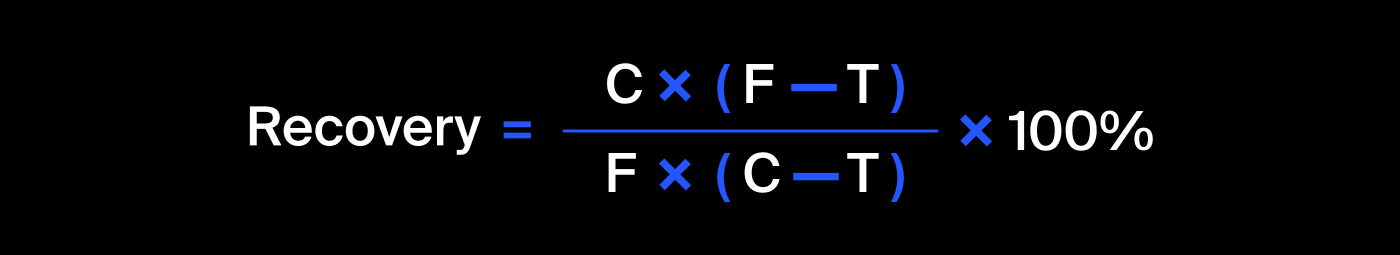

- C — доля золота в концентрате после флотации/очистки;
- F — доля золота в сырье/концентрате до флотации/очистки;
- T — доля золота в отвальных хвостах после флотации/очистки.

In [48]:
def Recovery(c,f,t): 
    recovery = c*(f-t)/(f*(c-t)) *100
    return recovery

Вычислим характеристику на обучающей выборке для **rougher.output.recovery** согласно заданию. 
Определим функцию для вычисления данного параметра при работе со строкой.

In [49]:
def ror(row): 
    c = row['rougher.output.concentrate_au']
    f = row['rougher.input.feed_au']
    t = row['rougher.output.tail_au']
    return Recovery(c,f,t)

Вычисляем значение параметра

In [50]:
gold_recovery_train.loc[abs(gold_recovery_train['rougher.input.feed_au']) < 0.000000001,:]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,2.116168,NaN,7.25,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1549.052155,-500.274820,1548.147964,-500.140456,1.551247e+03,-500.102150,1549.613537,-500.344154,652.624634,-1607.685064,-276.558327,NaN,0.0,0.0,0.342757,30.525966,0.0,0.0,NaN,0.005591,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1000.044075,-499.701093,1601.264122,-500.208509,1602.147192,-501.166016,1403.699349,-500.472778,1200.039757,-500.722503,1100.262371,-501.588772,0.0,0.0,0.0,0.0,25.023285,-498.788519,22.947632,-499.973364,24.008926,-499.771421,23.021715,-500.241633,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,7.25,0.003844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1549.558400,-500.299753,1548.453530,-499.997415,1.550885e+03,-499.430257,1548.365520,-499.846258,-1113.249700,-5862.022260,738.069870,NaN,0.0,0.0,0.334574,30.522523,0.0,0.0,NaN,0.001380,0.000254,NaN,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,999.863380,-500.412610,15

Похоже часть данных содержит нули как в значениях концентрации золота в руде, так и на выходе. Потому такие строки конечно следует выкинуть - ценности они не несут. 

In [51]:
gold_recovery_train = gold_recovery_train.dropna(subset=['rougher.input.feed_au'])
gold_recovery_train = gold_recovery_train.loc[abs(gold_recovery_train['rougher.input.feed_au']) > 0.000000001,:]
gold_recovery_train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [52]:
gold_recovery_train['rougher.output.recovery_check'] = gold_recovery_train.apply(ror,axis=1)


In [53]:
gold_recovery_train[['rougher.output.recovery','rougher.output.recovery_check']]

,rougher.output.recovery,rougher.output.recovery_check
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
16855,89.574376,89.574376
16856,87.724007,87.724007
16857,88.890579,88.890579
16858,89.858126,89.858126


Вычислим MAE между расчётами и имеющимся значением признака. Но сперва проверим исходные значения на пропуски

In [54]:
gold_recovery_train.loc[gold_recovery_train['rougher.output.recovery'].isna(),:]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_check
53,2016-01-17 05:00:00,5.919503,11.078044,6.215769,42.922611,71.308281,10.866006,1.577753,17.550397,2.476280,137.334448,13.944077,7.25,1.203816,10.096140,9.967757,19.338940,33.534196,15.530185,2.878396,6.711868,2.718301,1598.394630,-500.458080,1602.960131,-500.418604,1600.863989,-499.987692,1600.511126,-500.261028,39933.069105,3203.462131,3192.357901,2.320302,8.124270,3.253172,598.319124,52.130611,39.030467,7.548341,14.433785,7.799818,14.416890,7.797047,2.090477,1.459553,4.934392,3.507147,NaN,5.102708,0.909215,18.132700,2.187465,999.661447,-500.031802,1599.268574,-501.554117,1600.102406,-501.702500,1403.530218,-501.239410,1201.597520,-500.535422,1201.043695,-506.311877,12.977405,4.906992,9.904222,2.740749,26.082321,-499.698904,23.916400,-500.094545,25.012275,-500.403009,24.007706,-499.846645,13.972224,-548.238797,12.042964,-550.430774,9.989624,-499.606754,7.950446,-500.352648,12.011728,-599.043399,188.742102
129,2016-01-20 09:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,8.584221,NaN,7.25,0.

И они есть. 

Далее будем сравнивать только те значения, которые изначально были заполнены с посчитанными

In [55]:
import sklearn.metrics as metrics

In [56]:
filtr = ~gold_recovery_train['rougher.output.recovery'].isna()
metrics.mean_absolute_error(gold_recovery_train.loc[filtr,'rougher.output.recovery'],
                            gold_recovery_train.loc[filtr,'rougher.output.recovery_check'])

9.444891926100695e-15

Можно сказать ноль! Формула для расчета исходных данных использовалась та же.
Заполним пропуски сразу.

In [57]:
gold_recovery_train.loc[((gold_recovery_train['rougher.output.recovery_check']>100) | 
                        (gold_recovery_train['rougher.output.recovery_check']<0))
                        ,'rougher.output.recovery_check'].sort_values()

13453   -366924.161290
700     -112789.873301
16607    -68360.243330
13190    -48247.462756
14673    -28253.037156
             ...      
15697       803.625124
11727      2913.645471
16653      6343.566718
15606     10584.479953
13189     13802.071756
Name: rougher.output.recovery_check, Length: 260, dtype: float64

## 1.3. Анализ признаков, недоступных в тестовой выборке. 

Для начала определим список отличающихся (отсутствующих) признаков в тестовой выборке. 

In [58]:
features_not_in_test = [feature for feature in gold_recovery_full.columns if feature not in gold_recovery_test.columns]
features_not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

In [59]:
set(gold_recovery_full.columns) -set(gold_recovery_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Ответим на вопросы: 
Что это за параметры? К какому типу относятся?
    
Эти параметры относятся к категории рассчитываемых и выходных параметры продукта. Данные параметры выводятся для всех этапов, начиная с флотации и заканчивая финальными характеристиками техпроцесса. 
Эти параметры можно в целом отнести к категории "искомых"


## 1.4. Предобработка данных

### 1.4.1 Поиск дубликатов
Проверка на дубликаты.

In [60]:
gold_recovery_test.duplicated().sum()

0

In [61]:
gold_recovery_train.duplicated().sum()

0

In [62]:
gold_recovery_full.duplicated().sum()

0

Дубликатов не обнаружено

### 1.4.2 Работа с пропусками

In [63]:
gold_recovery_train.isna().any(axis=1).sum() / len(gold_recovery_train)

0.29459597899859136

Выявлено 29,5% строк с нулевыми значениями хотя бы в одной колонке. Значение достаточно велико. 

Логика положенная в основу восстановления данных будет следовать следующим принципам: 
1. Вероятнее всего обогащение руды происходит из одного месторождения. Параметры не могут радикально отличаться для пропущенных значений при прочих равных.
2. Скорее всего руда, близкая по времени будет более-менее одинаковой по свойствам. Геп возможен при смене партии с месторождения. Имеется ввиду, что до очистки руду доставляют с месторождения партиями и складируют. пока склад не "выберут" характеристики будут более менее одинаковыми.


Один из признаков мы уже восстановили согласно приведенной выше формуле. 
Осталось определить, какие еще признаки мы можем восстановить. Рассмотрим пропуски на базе тренировочных данных.

Данные будем рассматривать поэтапно. Устраним пропуски стадии флотации, первичной, вторичной, и финального этапа по-очереди. Для этого сгруппируем признаки по этапам

In [64]:
rougher = gold_recovery_train.columns[gold_recovery_train.columns.str.contains('^rougher')] 
primary_cleaner = gold_recovery_train.columns[gold_recovery_train.columns.str.contains('^primary_cleaner')] 
secondary_cleaner  = gold_recovery_train.columns[gold_recovery_train.columns.str.contains('^secondary_cleaner')] 
final  = gold_recovery_train.columns[gold_recovery_train.columns.str.contains('^final')] 

gold_recovery_train.loc[:,rougher].isna().any(axis=1).sum() / len(gold_recovery_train)

0.1648098348059931

Тут пропущенных значений уже меньше. Посмотрим колонки с пропусками.

In [65]:
gold_recovery_train.loc[:,rougher].isna().sum()

rougher.calculation.sulfate_to_au_concentrate            1
rougher.calculation.floatbank10_sulfate_to_au_feed       1
rougher.calculation.floatbank11_sulfate_to_au_feed       1
rougher.calculation.au_pb_ratio                          0
rougher.input.feed_ag                                    0
rougher.input.feed_pb                                  146
rougher.input.feed_rate                                227
rougher.input.feed_size                                158
rougher.input.feed_sol                                 210
rougher.input.feed_au                                    0
rougher.input.floatbank10_sulfate                      393
rougher.input.floatbank10_xanthate                      95
rougher.input.floatbank11_sulfate                      378
rougher.input.floatbank11_xanthate                     814
rougher.output.concentrate_ag                            0
rougher.output.concentrate_pb                            0
rougher.output.concentrate_sol                          

Пропуски есть почти везде. Но в отдельных колонках их мало. Есть пропуски в целевом признаке. Их восстанавливать будет неправильным подходом, поскольку они то и являются искомыми при обучении модели. 
Признаки, которые являются искомыми:
- "final.output.recovery"
- "rougher.output.recovery"

На мой непрофессиональный взгляд как золотодобытчика нельзя также восстанавливать значения в колонках, содержащих feed данные с золотом в составе (остальные компоненты на не сильно волнуют). И не стоит заниматься восстановлением данных в строках, где пропущено значительное количество информации.

In [66]:
gold_recovery_train.loc[:,rougher].shape[0]

15618

In [67]:
subset= ['final.output.recovery','rougher.output.recovery','rougher.input.feed_au']
# subset=['rougher.input.feed_ag',
#         'rougher.input.feed_pb', 
#         'rougher.input.feed_rate',
#         'rougher.input.feed_size',
#         'rougher.input.feed_sol',
#         ]#,        
#         'rougher.output.concentrate_au',
#         'rougher.state.floatbank10_d_air']
gold_recovery_train_cleaned = gold_recovery_train.dropna(subset=subset).dropna(thresh=60)
gold_recovery_train_cleaned.isna().sum()

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     0
final.output.tail_pb                                   100
final.output.tail_sol                                    5
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           19
primary_cleaner.input.depressant                        31
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                          99
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                   86
primary_cleaner.output.concentrate_sol                 2

In [68]:
gold_recovery_train_cleaned.shape[0]/gold_recovery_train.shape[0]

0.9058778332693046

Убедимся на всякий случай, что в признаках не оказались нулевые значения

In [69]:
gold_recovery_train_cleaned.loc[gold_recovery_train_cleaned['rougher.input.feed_au']==0,:]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_check


Теперь заполним пропуски в отсутствующих признаках. Проверим предположение №2 из данного параграфа: признаки меняются равномерно. Построим график для нескольких признаков в зависимости от времени и убедимся в "плавности" полученных кривых по параметрам.

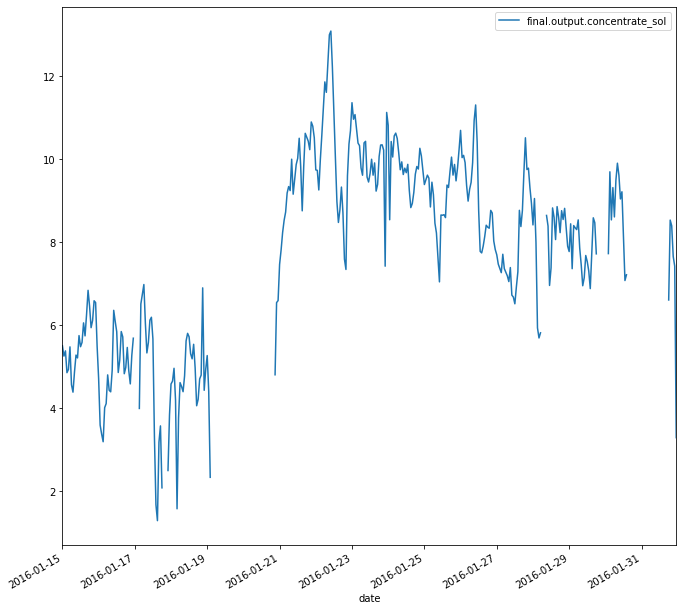

In [70]:
gold_recovery_train_cleaned.query('date < "2016-02-01"').plot(x='date', y='final.output.concentrate_sol', kind='line' ,figsize = (11,11))

Плавности изменения параметров нет! Но пропусков тут немного. 

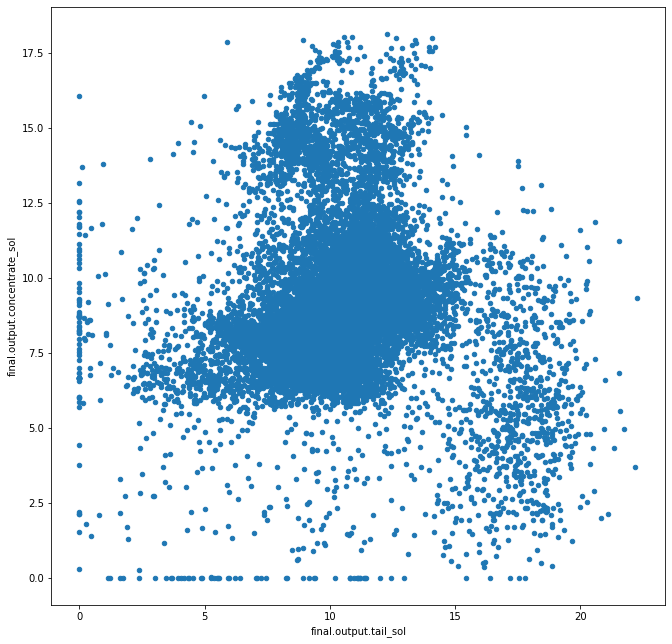

In [71]:
gold_recovery_train_cleaned.plot(x='final.output.tail_sol', y='final.output.concentrate_sol', kind='scatter' ,figsize = (11,11));

Похоже для заполнения пропусков мы можем пользоваться методом ближайших соседей в совокупности с линейной регрессией. Вопрос только в количестве моделей и отборе признаков для выявления зависимостей. 
На текущий момент мы воспользуемся методом ffill, как наиболее простым. 

In [77]:
len(gold_recovery_train_cleaned)

14148

In [73]:
gold_recovery_full_restore = gold_recovery_full.loc[gold_recovery_full.notna().all(axis=1),:].reset_index(drop=True).drop(columns=['date'])
gold_recovery_full_restore

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.497069,19.369147,34.118526,16.250511,3.049646

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

In [37]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [79]:
%%time
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(gold_recovery_train_cleaned.filter(regex ='^rougher.input.'))

CPU times: user 4.52 s, sys: 5.35 s, total: 9.87 s
Wall time: 9.82 s


/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, tol=0.001, verbose=0)

In [80]:
X = gold_recovery_train_cleaned.filter(regex ='^rougher.input.')
X

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate
0,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818
1,6.161113,2.266033,525.290581,57.278666,35.753385,6.478583,11.971193,6.005766,11.996163,6.012594
2,6.116455,2.159622,530.026610,57.510649,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633
3,6.043309,2.037807,542.590390,57.792734,36.862241,6.118189,11.630094,6.203177,11.692450,6.196578
4,6.060915,1.786875,540.531893,56.047189,34.347666,5.663707,10.957755,6.198826,10.960521,6.194897
...,...,...,...,...,...,...,...,...,...,...
16855,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069
16856,6.121323,4.144989,559.031805,119.499241,38.591551,4.838619,7.356687,9.304952,7.095508,9.297924
16857,5.970515,4.020002,555.682872,122.262690,40.074026,4.525061,6.586020,9.299606,6.584130,9.300133
16858,6.048130,3.902537,544.731687,123.742430,39.713906,4.362781,6.210119,9.297709,6.209517,9.297194


In [81]:
imp_mean.transform(X)

array([[  6.10037804,   2.28491211, 523.54632568, ...,   6.00798988,
         11.83674335,   6.00581837],
       [  6.16111348,   2.26603263, 525.2905809 , ...,   6.00576591,
         11.99616279,   6.01259367],
       [  6.1164549 ,   2.15962163, 530.02661044, ...,   6.19737694,
         11.9203052 ,   6.20463318],
       ...,
       [  5.97051525,   4.02000219, 555.68287198, ...,   9.29960607,
          6.58413031,   9.30013304],
       [  6.04813022,   3.90253661, 544.73168688, ...,   9.29770949,
          6.20951712,   9.29719433],
       [  6.15871773,   3.87572678, 555.82020835, ...,   9.30861213,
          6.16893878,   9.30985188]])

In [83]:
X.isna().any(axis=1).sum() / len(gold_recovery_train)

0.04782942758355743

In [85]:
pd.DataFrame(imp_mean.transform(X),columns = X.columns).isna().any(axis=1).sum() / len(gold_recovery_train)

0.0

In [39]:
gold_recovery_full.isna().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
22711    False
22712    False
22713    False
22714    False
22715    False
Length: 22716, dtype: bool

In [40]:
gold_recovery_train_cleaned = gold_recovery_train_cleaned.fillna(method = 'ffill')
gold_recovery_train_cleaned.isna().sum()

date                                                  0
final.output.concentrate_ag                           0
final.output.concentrate_pb                           0
final.output.concentrate_sol                          0
final.output.concentrate_au                           0
final.output.recovery                                 0
final.output.tail_ag                                  0
final.output.tail_pb                                  0
final.output.tail_sol                                 0
final.output.tail_au                                  0
primary_cleaner.input.sulfate                         0
primary_cleaner.input.depressant                      0
primary_cleaner.input.feed_size                       0
primary_cleaner.input.xanthate                        0
primary_cleaner.output.concentrate_ag                 0
primary_cleaner.output.concentrate_pb                 0
primary_cleaner.output.concentrate_sol                0
primary_cleaner.output.concentrate_au           

<font color='green'>Ок, да, так можно. </font>


In [664]:
gold_recovery_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


Восстановим и тестовые данные аналогично тренировочным.

In [672]:
gold_recovery_test_cleaned = gold_recovery_test.fillna(method = 'ffill')
gold_recovery_test_cleaned.isna().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

***Сначала уберем значения с пустыми строками***

In [717]:
subset= ['final.output.recovery','rougher.output.recovery','rougher.input.feed_au']
# subset=['rougher.input.feed_ag',
#         'rougher.input.feed_pb', 
#         'rougher.input.feed_rate',
#         'rougher.input.feed_size',
#         'rougher.input.feed_sol',
#         ]#,        
#         'rougher.output.concentrate_au',
#         'rougher.state.floatbank10_d_air']
gold_recovery_full_cleaned = gold_recovery_full.dropna(subset=subset)#.dropna(thresh=60)
gold_recovery_full_cleaned.isna().sum()

date                                                     0
final.output.concentrate_ag                              1
final.output.concentrate_pb                              1
final.output.concentrate_sol                           211
final.output.concentrate_au                              0
final.output.recovery                                    0
final.output.tail_ag                                     1
final.output.tail_pb                                   101
final.output.tail_sol                                    6
final.output.tail_au                                     0
primary_cleaner.input.sulfate                           24
primary_cleaner.input.depressant                        37
primary_cleaner.input.feed_size                          0
primary_cleaner.input.xanthate                         104
primary_cleaner.output.concentrate_ag                    0
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.output.concentrate_sol                 3

In [667]:
gold_recovery_full_cleaned = gold_recovery_full_cleaned.loc[gold_recovery_full_cleaned['final.output.concentrate_au']!=0,:]

<font color='blue'>~~Всю предобработку лучше перенести в предыдущий раздел.~~ 

Здесь так же, вместо «!=0» лучше написать «>0.00000001».
</font>

<font color='purple'> Предобработка была перемещена </font>

*Мусор*
Посмотрим, какие временные данные.
Стоит посмотреть по методу поиска ближайших соседей. Я пока не могу сказать почему, но на мой взгляд стоит исключить  

### 1.4.3 Изменение типов данных
Кроме первичного преобразования дат при непосредственном импорте следует просмотреть сами признаки.


In [70]:
gold_recovery_train_cleaned.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_check
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629

In [71]:
gold_recovery_train_cleaned['primary_cleaner.input.feed_size'].value_counts()

7.250000    311
7.000000    210
7.300000    204
7.700000    158
7.280000    144
           ... 
6.503333      1
7.372667      1
9.180000      1
6.325000      1
7.336667      1
Name: primary_cleaner.input.feed_size, Length: 3732, dtype: int64

Беглый осмотр выявил, что почти все значения уникальны. Наверное за исключением гранул сырья. Сократим размер, занимаемый данными в памяти через downcast 

In [72]:
def downcast_floats(df,col_name_list):
    for col_name in col_name_list:
        df[col_name] = pd.to_numeric(df[col_name], downcast = 'float')
    return df

In [73]:
float_cols = gold_recovery_train_cleaned.columns.to_list()
float_cols.remove('date')
float_cols
gold_recovery_train_cleaned = downcast_floats(gold_recovery_train_cleaned,float_cols)
gold_recovery_train_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14148 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14148 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float32       
 2   final.output.concentrate_pb                         14148 non-null  float32       
 3   final.output.concentrate_sol                        14148 non-null  float32       
 4   final.output.concentrate_au                         14148 non-null  float32       
 5   final.output.recovery                               14148 non-null  float32       
 6   final.output.tail_ag                                14148 non-null  float32       
 7   final.output.tail_pb                                14148 non-null  float32       
 8   final.

In [74]:
float_cols = gold_recovery_test_cleaned.columns.to_list()
float_cols.remove('date')
float_cols
gold_recovery_test_cleaned = downcast_floats(gold_recovery_test_cleaned,float_cols)
gold_recovery_test_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5856 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5856 non-null   float32       
 2   primary_cleaner.input.depressant            5856 non-null   float32       
 3   primary_cleaner.input.feed_size             5856 non-null   float32       
 4   primary_cleaner.input.xanthate              5856 non-null   float32       
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float32       
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float32       
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float32       
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float32       
 9   primary_

# 2. Анализ данных
## 2.1. Отслеживание изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Начнем с построения гистограмм и линейных графиков.

In [104]:
import seaborn as sns
sns.set(style="whitegrid")

In [211]:
subset_concentrate= ['final.output.recovery','rougher.output.recovery','rougher.input.feed_au','rougher.output.concentrate_au']
gold_recovery_full_cleaned = gold_recovery_full.dropna(subset=subset_concentrate).dropna(thresh=60)

info = pd.DataFrame()


def show_plots(data, subset):    
    plt.figure(figsize=(12,10))
    for name in subset:        
        ax = sns.kdeplot(data[name], shade=True, legend = True)         
#         data[name].hist(bins=_bins,alpha =0.4,range=_range)        
        info.at[name[:-3], name[-2:]] = data[name].mean()

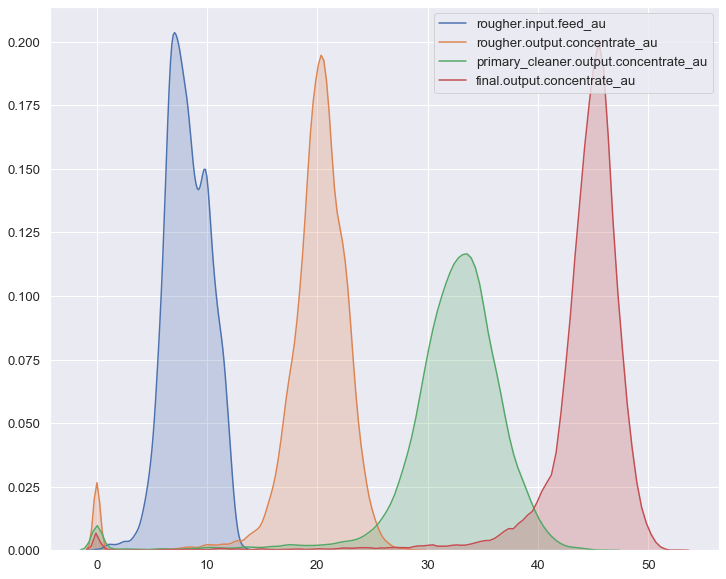

In [212]:
_subset = ['rougher.input.feed_au',
           'rougher.output.concentrate_au',
           'primary_cleaner.output.concentrate_au',
           'final.output.concentrate_au']

show_plots(gold_recovery_full_cleaned,_subset)

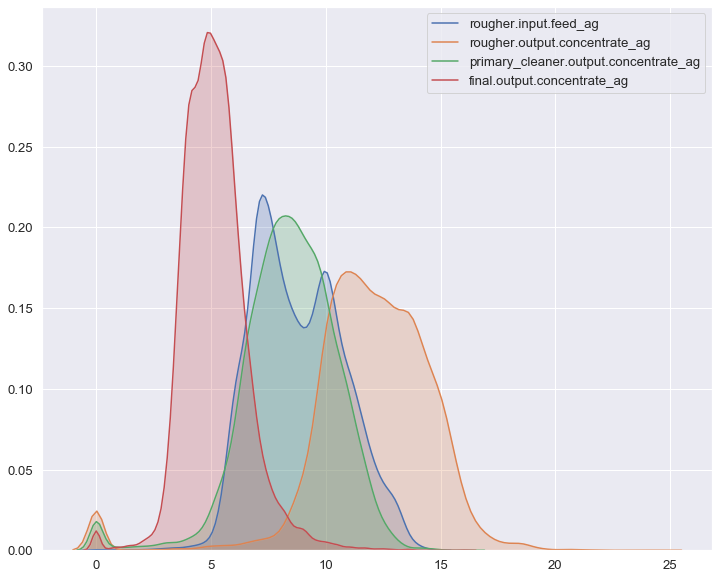

In [213]:
_subset = ['rougher.input.feed_ag',
           'rougher.output.concentrate_ag',
           'primary_cleaner.output.concentrate_ag',
           'final.output.concentrate_ag']

show_plots(gold_recovery_full_cleaned,_subset)

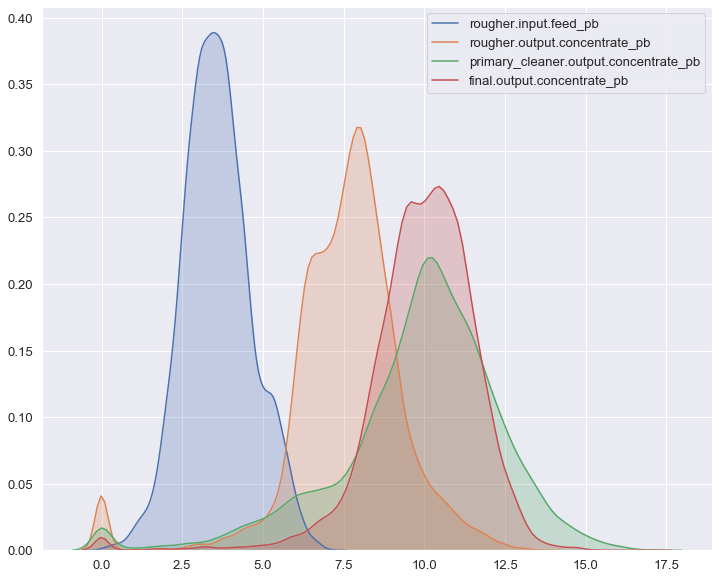

In [214]:
_subset = ['rougher.input.feed_pb',
           'rougher.output.concentrate_pb',
           'primary_cleaner.output.concentrate_pb',
           'final.output.concentrate_pb']

show_plots(gold_recovery_full_cleaned,_subset)

In [215]:
gathered_metal = info
gathered_metal

,au,ag,pb
rougher.input.feed,8.266011,8.794761,3.598054
rougher.output.concentrate,19.772006,11.994673,7.606263
primary_cleaner.output.concentrate,32.119441,8.442259,9.829551
final.output.concentrate,44.076559,5.168439,9.978844


In [216]:
gathered_metal.index = ['0_Сырье', '1_Концентрация после флотации', '2_Концентрация первичной очистки', '3_Концентрация финальной очистки']

In [217]:
gathered_metal

,au,ag,pb
0_Сырье,8.266011,8.794761,3.598054
1_Концентрация после флотации,19.772006,11.994673,7.606263
2_Концентрация первичной очистки,32.119441,8.442259,9.829551
3_Концентрация финальной очистки,44.076559,5.168439,9.978844


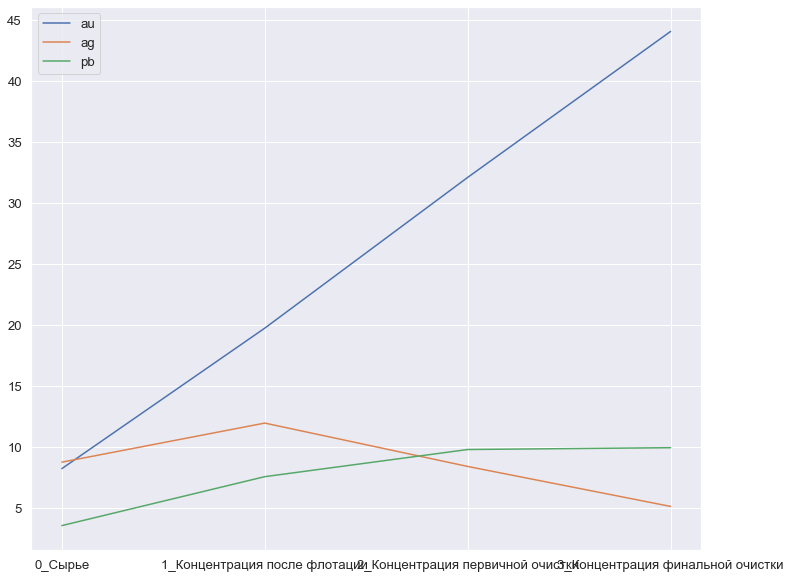

In [231]:
sns.set(font_scale=1.2)


plt.figure(figsize=(12,10))
for i in gathered_metal.columns:    
    ax = sns.lineplot(data=gathered_metal[i],label=i)
#     ax.set_xticklabels(chart.get_xticklabels(), rotation=60,horizontalalignment='right')
#     for item in ax.get_xticklabels():
#         item.set_rotation(90)
        

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()

# for i in gathered_metal.columns:
#     ax.plot(gathered_metal.index, gathered_metal[i], label=i)    
# ax.legend()
# fig = plt.figure()
# plt.show()

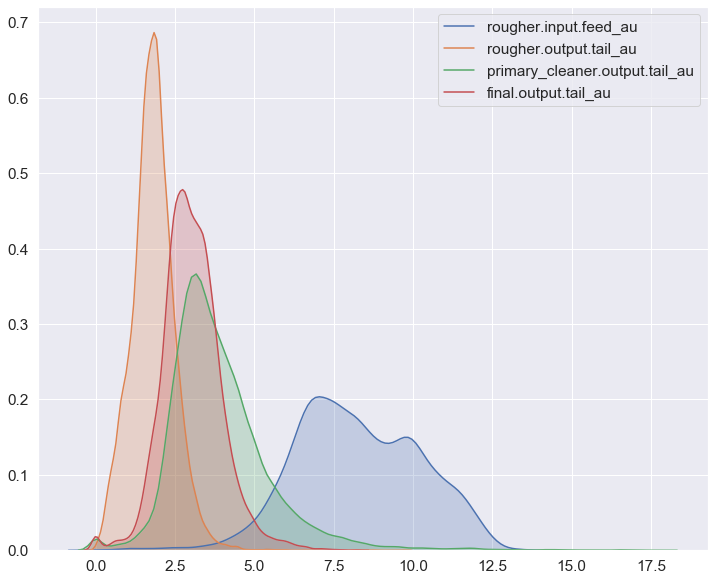

In [219]:
info = pd.DataFrame()
_subset = ['rougher.input.feed_au',
           'rougher.output.tail_au',
           'primary_cleaner.output.tail_au',
           'final.output.tail_au']

show_plots(gold_recovery_full_cleaned,_subset)

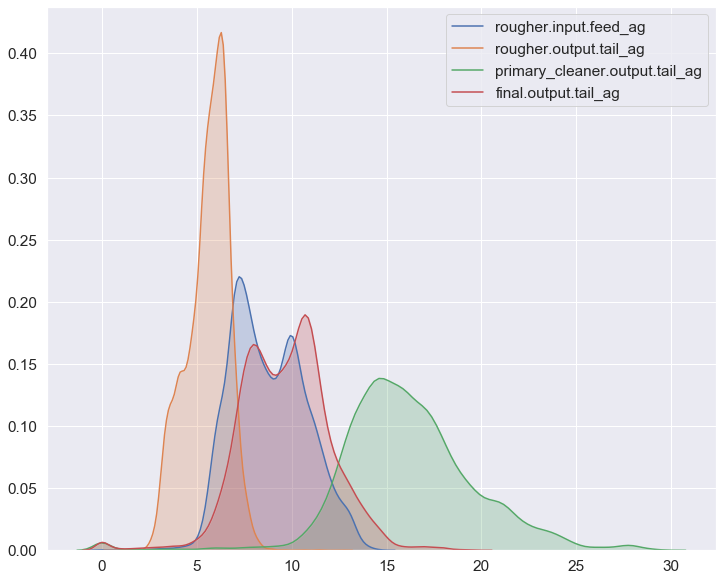

In [220]:
_subset = ['rougher.input.feed_ag',
           'rougher.output.tail_ag',
           'primary_cleaner.output.tail_ag',
           'final.output.tail_ag']

show_plots(gold_recovery_full_cleaned,_subset)

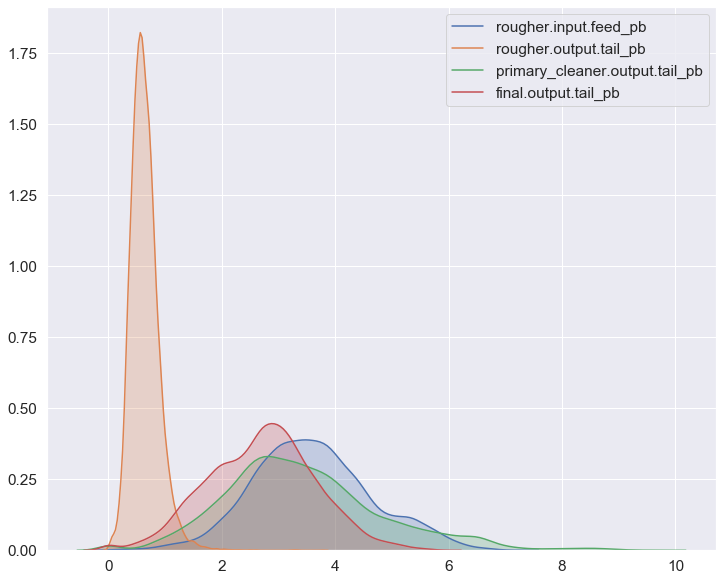

In [221]:
_subset = ['rougher.input.feed_pb',
           'rougher.output.tail_pb',
           'primary_cleaner.output.tail_pb',
           'final.output.tail_pb']

show_plots(gold_recovery_full_cleaned,_subset)

In [222]:
info

,au,ag,pb
rougher.input.feed,8.266011,8.794761,3.598054
rougher.output.tail,1.816359,5.588958,0.645771
primary_cleaner.output.tail,3.914218,16.145755,3.435629
final.output.tail,3.042464,9.688472,2.705829


In [223]:
tail_metal = info

In [227]:
tail_metal.index = ['0_Сырье', '1_Хвосты после флотации', '2_Хвосты первичной очистки', '3_Хвосты финальной очистки']

In [228]:
tail_metal

,au,ag,pb
0_Сырье,8.266011,8.794761,3.598054
1_Хвосты после флотации,1.816359,5.588958,0.645771
2_Хвосты первичной очистки,3.914218,16.145755,3.435629
3_Хвосты финальной очистки,3.042464,9.688472,2.705829


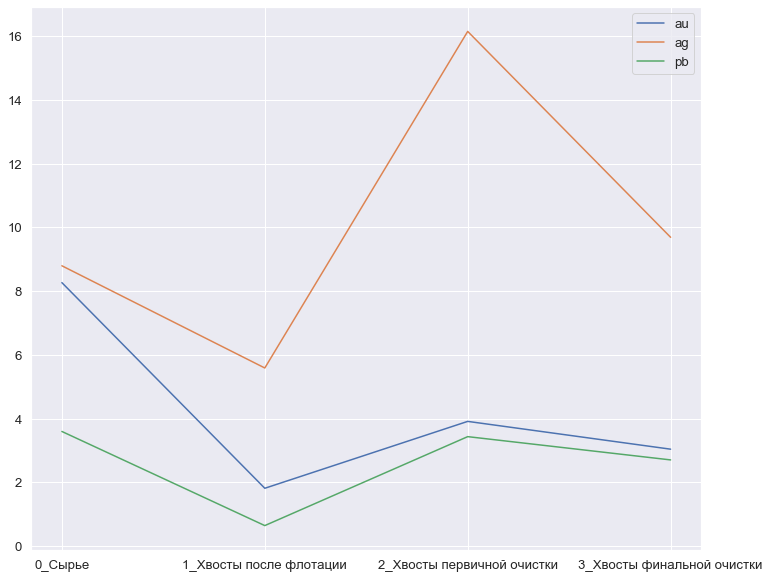

In [229]:
sns.set(font_scale=1.2)

plt.figure(figsize=(12,10))
for i in (tail_metal.columns):    
    ax = sns.lineplot(data=tail_metal[i],label=i)

# fig, ax = plt.subplots()

# for i in info.columns:
#     ax.plot(info.index, info[i], label=i)    
# ax.legend()
# fig = plt.figure(figsize=(10,10))
# plt.show()

In [230]:
ind = ['au','ag','pb']
gathered_metal.reset_index()[ind] / tail_metal.reset_index()[ind]

,au,ag,pb
0,1.000000,1.000000,1.000000
1,10.885514,2.146138,11.778572
2,8.205840,0.522878,2.861063
3,14.487124,0.533463,3.687907


Выводы:
1. Весь процесс направлен на повышение концентрации золота. Прочие компоненты руды извлекаются с меньшей эффективностью
2. Соотношение количества металла оказывающегося идущего на дальнейшую переработку и оказывающихся в "хвостах" уверенно больше 1 только для золота и для свинца. А вот серебра больше откажется в итоге в хвостах.
3. Концентрация серебра в итоговом продукте падает. Концентрация свинца напротив растет. 

## 2.2. Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках

Рассмотрим выборки обучающие и тестовые. Для начала наложим гистограммы двух выборок друг на друга.

<Figure size 432x288 with 0 Axes>

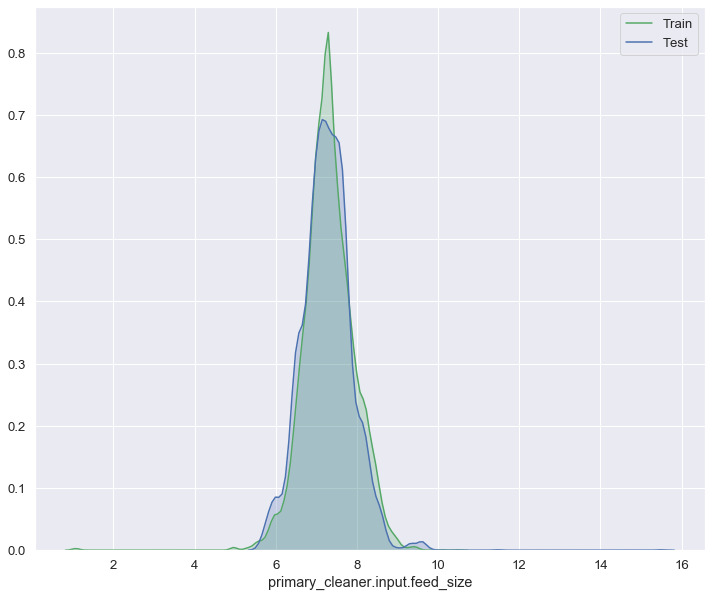

In [244]:
# f, axes = plt.subplots(figsize=(7, 7), sharex=True)
sns.despine(left=True)
plt.figure(figsize=(12,10))
sns.distplot(gold_recovery_train_cleaned['primary_cleaner.input.feed_size'], hist=False, color="g",label = 'Train', kde_kws={"shade": True})
sns.distplot(gold_recovery_test_cleaned['primary_cleaner.input.feed_size'], hist=False, color="b",label = 'Test', kde_kws={"shade": True})

In [246]:
# plt.figure(figsize=(12,10))
# gold_recovery_train_cleaned['primary_cleaner.input.feed_size'].hist(bins = 32,range = (0,16))
# gold_recovery_test_cleaned['primary_cleaner.input.feed_size'].hist(bins = 32,range = (0,16))

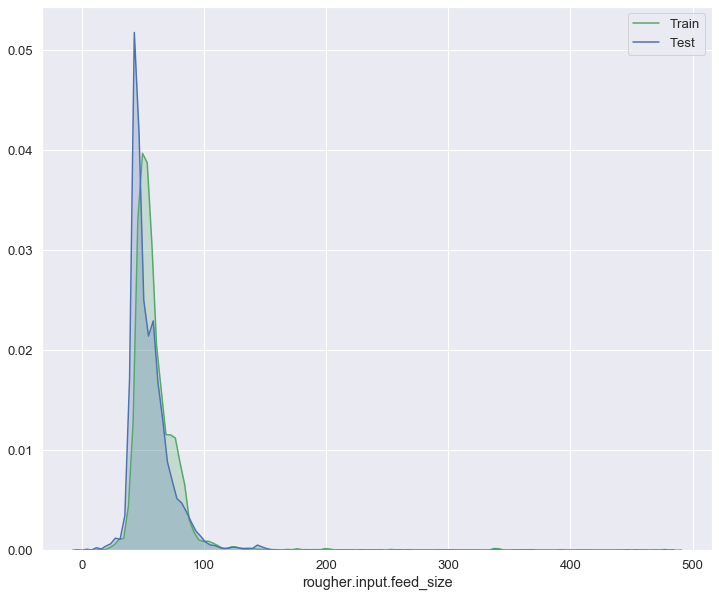

In [249]:
plt.figure(figsize=(12,10))
sns.distplot(gold_recovery_train_cleaned['rougher.input.feed_size'], hist=False, color="g",label = 'Train', kde_kws={"shade": True})
sns.distplot(gold_recovery_test_cleaned['rougher.input.feed_size'], hist=False, color="b",label = 'Test', kde_kws={"shade": True})
# gold_recovery_train_cleaned['rougher.input.feed_size'].hist(bins = 22,range = (0,220))
# gold_recovery_test_cleaned['rougher.input.feed_size'].hist(bins = 22,range = (0,220))

Выглядят похожими. Рассмотрим теперь статистическую информацию по каждой выборке. 

In [252]:
feed_size_features_names = ['primary_cleaner.input.feed_size','rougher.input.feed_size']
gold_recovery_train_cleaned_feed_size = gold_recovery_train_cleaned[feed_size_features_names].describe()
gold_recovery_test_cleaned_feed_size = gold_recovery_test_cleaned[feed_size_features_names].describe()
feed_size_train_test = pd.merge(gold_recovery_train_cleaned_feed_size,
                                gold_recovery_test_cleaned_feed_size,
                                left_index = True,
                                right_index = True,
                                suffixes = ('-train','-test'))
feed_size_train_test

,primary_cleaner.input.feed_size-train,rougher.input.feed_size-train,primary_cleaner.input.feed_size-test,rougher.input.feed_size-test
count,14148.000000,14148.000000,5856.000000,5856.000000
mean,7.322209,60.239380,7.264610,55.898838
std,0.614081,23.006063,0.611525,22.707983
min,1.080000,9.659576,5.650000,0.046369
25%,6.960000,48.966746,6.885625,43.852884
50%,7.290000,55.269154,7.259333,49.964796
75%,7.700000,66.009336,7.650000,61.628004
max,10.470000,484.967468,15.500000,477.445465


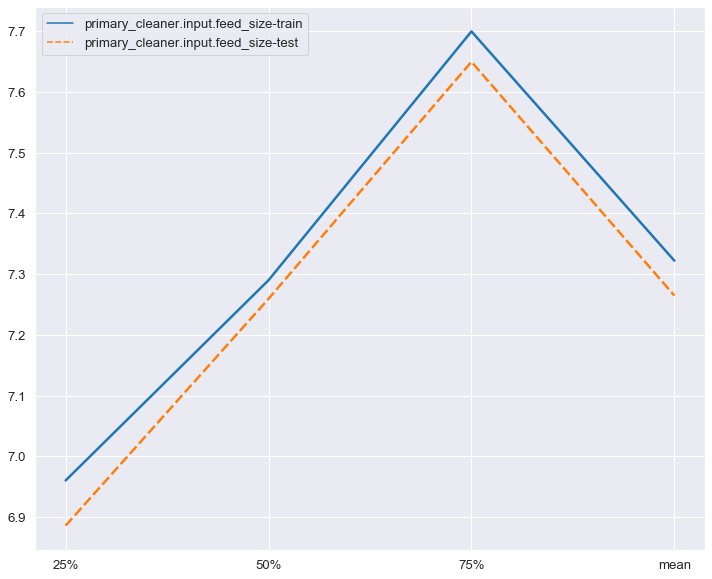

In [255]:
rows = ['25%','50%','75%', 'mean']
feed_size_train_test = feed_size_train_test.loc[feed_size_train_test.index.isin(rows),:]

plt.figure(figsize=(12,10))
sns.lineplot(data=feed_size_train_test[['primary_cleaner.input.feed_size-train','primary_cleaner.input.feed_size-test']], palette="tab10", linewidth=2.5)
# fig, ax = plt.subplots()

# for column in feed_size_train_test.columns:
# #     .plot(x='index', y=column, kind='line')
#     ax.plot(feed_size_train_test.index, feed_size_train_test[column], label=column)    
    
#     ax.legend()
    
# fig = plt.figure(figsize=(10,10))
# plt.show()

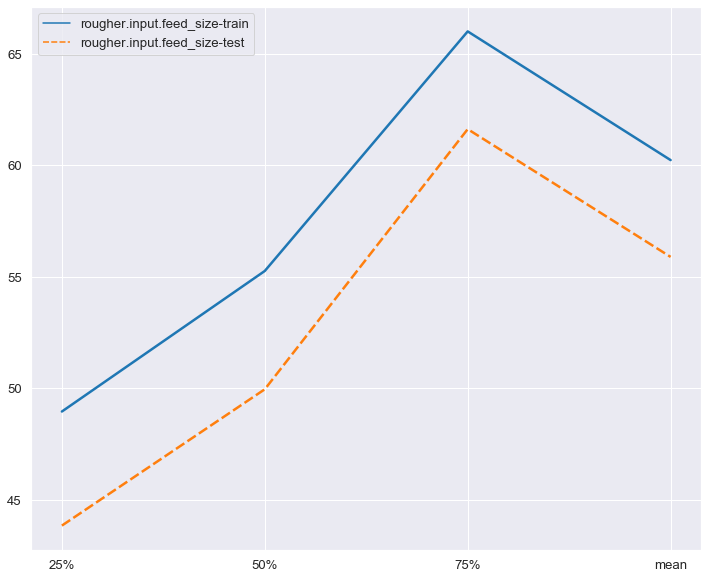

In [257]:
plt.figure(figsize=(12,10))
sns.lineplot(data=feed_size_train_test[['rougher.input.feed_size-train','rougher.input.feed_size-test']], palette="tab10", linewidth=2.5)

In [258]:
gold_recovery_test_cleaned_feed_size/gold_recovery_train_cleaned_feed_size

,primary_cleaner.input.feed_size,rougher.input.feed_size
count,0.413910,0.413910
mean,0.992134,0.927945
std,0.995838,0.987043
min,5.231481,0.004800
25%,0.989314,0.895565
50%,0.995793,0.904027
75%,0.993507,0.933626
max,1.480420,0.984490


Имеются отличия в размерах гранул до флотации между тестовой и обучающей выборкой. Далее эти различия нивелируются. 

Попробуем оценить равенство средних статистическими методами.

Проверим распределение на нормальность с помощью теста Шапиро:

In [259]:
from statsmodels.graphics.gofplots import qqplot
gold_recovery_train_cleaned['primary_cleaner.input.feed_size'].sort_values()

15691     1.08
15696     1.08
15695     1.08
15690     1.08
15694     1.08
         ...  
8227      9.50
2925     10.10
2926     10.10
1553     10.47
1552     10.47
Name: primary_cleaner.input.feed_size, Length: 14148, dtype: float32

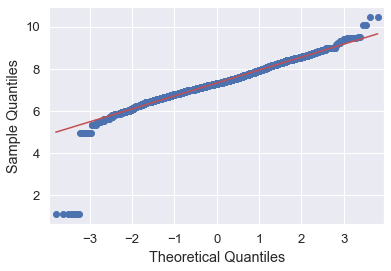

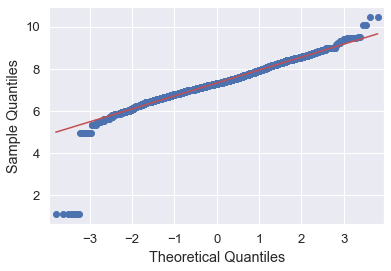

In [260]:
qqplot(gold_recovery_train_cleaned['primary_cleaner.input.feed_size'], line='s')

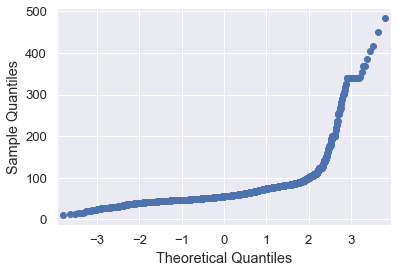

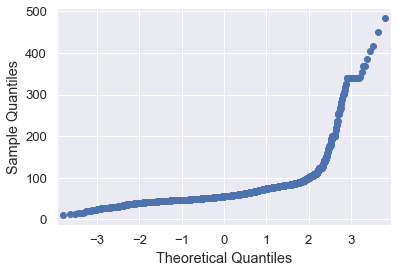

In [261]:
qqplot(gold_recovery_train_cleaned['rougher.input.feed_size'])

In [262]:
from scipy import stats
stats.shapiro(gold_recovery_train_cleaned['primary_cleaner.input.feed_size'])

C:\Users\pnedviga\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.968298614025116, 0.0)

In [263]:
stats.shapiro(gold_recovery_test_cleaned['primary_cleaner.input.feed_size'])

(0.9722580909729004, 3.1645697946205827e-32)

In [264]:
stats.shapiro(gold_recovery_train_cleaned['rougher.input.feed_size'])

(0.5610287189483643, 0.0)

In [265]:
stats.shapiro(gold_recovery_test_cleaned['rougher.input.feed_size'])

(0.5724121332168579, 0.0)

Второе значение в парах чисел является вероятностью, что значения в выборке имеют нормальное распределение. 

Критерий нормальности для доверительной вероятности при alpha  = 0.05 не выполняется. Вероятность меньше порогового значения. Статистические стесты для нормальных распределений нам не подойдут. 

Воспользуемся *бутсрепом*. 

Нулевая гипотеза: средние значения двух выборок одинаковы.
Уровень статистической значимости примем равным 0.05

In [273]:
sample_A = gold_recovery_train_cleaned['rougher.input.feed_size']
sample_B =gold_recovery_test_cleaned['rougher.input.feed_size']
print(f'длина sample_A {len(sample_A)} \nдлина sample_B {len(sample_B)}')

длина sample_A 14148 
длина sample_B 5856


In [272]:
len(gold_recovery_train_cleaned['rougher.input.feed_size'])

14148

In [275]:
AB_difference =  sample_A.mean() - sample_B.mean()
display(sample_A.mean())
AB_difference

60.2393798828125

4.340541839599609

Разница средних между выборками 4.3

In [276]:
alpha = 0.05
state = np.random.RandomState(12345)
bootstrap_samples = 3000

In [277]:
count = 0

for i in range(bootstrap_samples):
    # Масштабируем меньшую выборкуи записываем большую
    samples_A = (sample_A.sample(len(sample_B), ### ошибка  - А ведь специально уделил внимание и прокосячил!
                         replace=True, 
                         random_state=state))
    samples_B = sample_B
    
    # объединим выборки
    united_samples = pd.concat([samples_A, samples_B])

    # создадим подвыборку
    subsample = united_samples.sample(frac=1, replace=True, random_state=state)
    
    # разобьем подвыборку пополам
    subsample_A = subsample[:len(samples_A)]
    subsample_B = subsample[len(samples_A):]

    # найдите разницу средних
    bootstrap_difference = subsample_A.mean() - subsample_B.mean()
    #print(bootstrap_difference)
    # если разница не меньше фактической, увеличиваем счётчик
    if bootstrap_difference >= AB_difference:
        count += 1

# p-value равно доле превышений значений
pvalue = 1. * count / bootstrap_samples
print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего, среднее значение выборок разное")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, среднее значение выборок генеральной совокупности одинаковое")

p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, среднее значение выборок разное


In [280]:
gold_recovery_test_cleaned

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800903,14.993117,8.080000,1.005021,1398.981323,-500.225586,1399.144897,-499.919739,1400.103027,-500.704376,1399.001709,-499.485138,13.128569,5.636710,489.793640,62.710453,42.022442,12.084103,16.922876,6.153480,16.867517,6.150709,1001.849304,-350.301270,1249.738647,-399.107544,1249.750488,-399.396729,1198.287842,-399.488586,999.472229,-399.530975,949.566162,-398.180817,24.938200,-500.490967,14.947606,-500.013824,20.018166,-450.395996,13.987059,-449.831512,12.023554,-497.795837,8.016657,-501.289154,7.946562,-432.317841,4.872511,-500.037445,26.705889,-499.709412
1,2016-09-01 01:59:59,215.392456,14.987472,8.080000,0.990469,1398.777954,-500.057434,1398.055420,-499.778168,1396.151001,-499.240173,1399.508057,-500.416321,13.036280,5.526065,490.104523,61.961163,41.187904,11.918977,17.002533,5.999043,16.996063,6.002315,998.690796,-350.425690,1248.395508,-399.946014,1249.514404,-399.630798,1200.506470,-399.942444,1000.002136,-399.491516,950.200012,-405.787506,24.923466,-499.813965,14.930873,-500.764465,19.988503,-450.114014,14.092980,-450.059174,12.058140,-498.695770,8.130980,-499.634216,7.958270,-525.839661,4.878850,-500.162384,25.019939,-499.819427
2,2016-09-01 02:59:59,215.259949,12.884933,7.786667,0.996043,1398.493652,-500.868347,1398.860474,-499.764526,1398.075684,-502.151520,1399.497070,-499.715485,13.138412,5.426561,489.617981,66.903809,42.546295,12.091331,16.992519,5.850632,16.982096,5.853594,998.516724,-349.783539,1247.440796,-400.264343,1248.207153,-401.074402,1199.770020,-400.790588,999.925537,-399.237000,950.320496,-400.864349,24.908731,-500.304047,14.996511,-500.993835,20.039690,-450.263153,14.077881,-449.661011,11.962366,-498.767487,8.096892,-500.827423,8.071055,-500.801666,4.905125,-499.828522,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336243,12.006805,7.640000,0.863514,1399.618164,-498.863586,1397.440063,-499.211029,1400.129272,-498.355865,1401.065186,-501.038727,12.400507,5.114758,476.618134,59.865917,41.060196,12.181598,16.532143,5.801935,16.515276,5.803657,1000.276611,-350.172607,1251.322632,-398.655304,1250.493652,-399.746735,1199.398682,-397.50

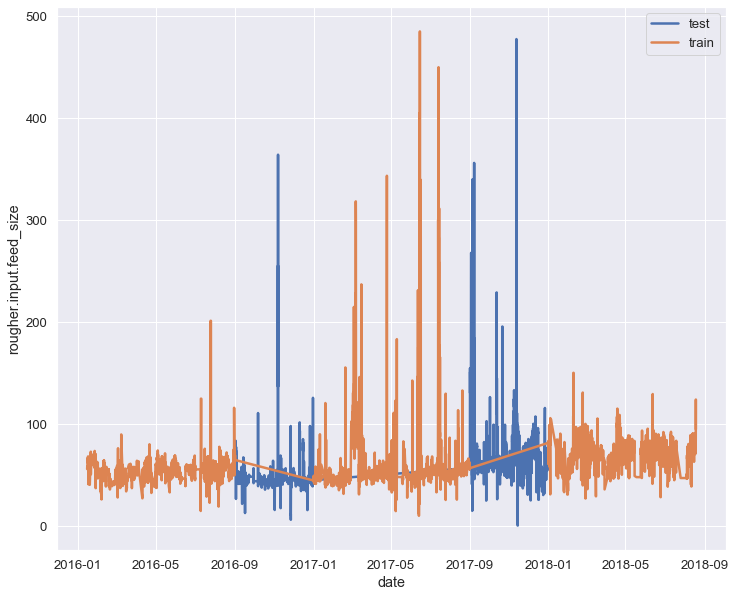

In [284]:
plt.figure(figsize=(12,10))
sns.lineplot(data=gold_recovery_test_cleaned, x = 'date', y= 'rougher.input.feed_size', label = 'test', palette="tab10", linewidth=2.5)
sns.lineplot(data=gold_recovery_train_cleaned, x = 'date', y= 'rougher.input.feed_size', label = 'train', palette="tab10", linewidth=2.5)

### Выводы. 
1. Выборки немного отличаются по размеру фракций гранул до флотации в границах 8%. 
2. И выборки не отличаются существенно после флотации. 
3. Причина отличий - разные временные промежутки используемых данных
Можно предположить, что размер гранул на старте не радикально влияет на последующий техпроцесс.

## 2.3.  Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 
Ответы на вопросы:
1. Заметили аномальные значения в суммарном распределении или нет? 
2. Если они есть, стоит ли их удалять из обеих выборок? 
3. Опишите выводы и удалите аномалии.

 По условиям задачи сырье описывается в задаче через  *Rougher feed — исходное сырье*. Сперва вычленим колонки с параметрами концентрации сырья на разных этапах.

In [286]:
gold_recovery_train_cleaned.columns.to_list()

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

Формируем списки имен признаков для рассмотрения

In [299]:
import re
metals = ['au','ag','pb','sol']
metals_labels = ['концентрация в руде ',
                 'концентрация после флотации ',
                 'концентрация после первичной очистки ',
                 'финальная концентрация ']
concentrations = ['rougher.input.feed',
                 'rougher.output.concentrate',
                 'primary_cleaner.output.concentrate',
                 'final.output.concentrate']
metals_re = [r'au$',r'ag$',r'pb$',r'sol$']
concentrations_re = [r'^rougher.input',
                     r'^rougher.output.concentrate',
                     r'^primary_cleaner.output.concentrate',
                     r'^final.output.concentrate']
metals_features =['rougher.input.feed_ag',
         'rougher.input.feed_pb',
         'rougher.input.feed_sol',
         'rougher.input.feed_au',
         'rougher.output.concentrate_ag', 
         'rougher.output.concentrate_pb',
         'rougher.output.concentrate_sol',
         'rougher.output.concentrate_au',
         'primary_cleaner.output.concentrate_ag',
         'primary_cleaner.output.concentrate_pb',
         'primary_cleaner.output.concentrate_sol',
         'primary_cleaner.output.concentrate_au',
         'final.output.concentrate_ag',
         'final.output.concentrate_pb',
         'final.output.concentrate_sol',
         'final.output.concentrate_au']

Колонки подготовлены. Добавим столбцы с суммами по концентрации веществ на каждом этапе.

In [309]:
for re_con,con in zip(concentrations_re,concentrations):
    res = [i for i in metals_features if re.search(re_con, i)]
    gold_recovery_full_cleaned[con] = gold_recovery_full_cleaned[res].sum(axis=1)
    display(gold_recovery_full_cleaned[con])

0        51.680034
1        50.659114
2        50.609929
3        51.061546
4        47.859163
           ...    
22711    53.415050
22712    53.696482
22713    54.589604
22714    54.027355
22715    53.535054
Name: rougher.input.feed, Length: 19438, dtype: float64

0        66.424950
1        67.012710
2        66.103793
3        65.752751
4        65.908382
           ...    
22711    70.781325
22712    70.539603
22713    55.376330
22714    69.201689
22715    69.544003
Name: rougher.output.concentrate, Length: 19438, dtype: float64

0        72.640924
1        72.543485
2        72.095042
3        59.957723
4        71.321010
           ...    
22711    59.001692
22712    59.703912
22713    59.561096
22714    57.216686
22715    55.748041
Name: primary_cleaner.output.concentrate, Length: 19438, dtype: float64

0        63.644396
1        63.957723
2        64.311180
3        63.573449
4        64.004667
           ...    
22711    68.098589
22712    68.274362
22713    68.226068
22714    68.200449
22715    68.353154
Name: final.output.concentrate, Length: 19438, dtype: float64

Надо пройти по техпроцессу для каждого из металлов и посмотреть распределения. Напишем функцию печати

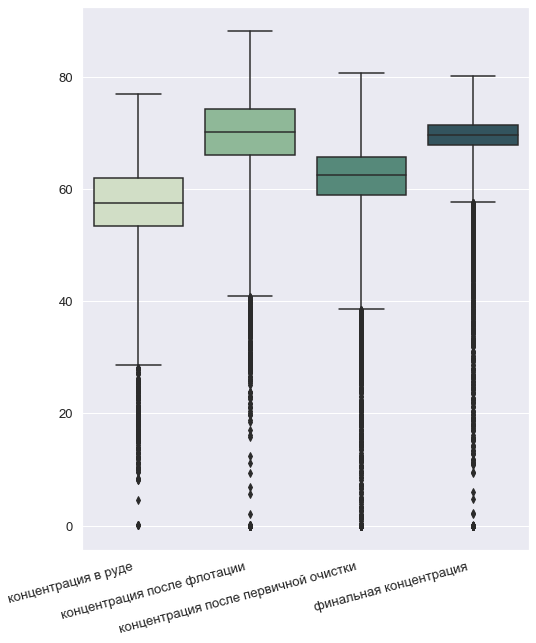

In [319]:
def plot_conc(data,columns,labels):    
    plt.figure(figsize=(8,10))    
    pal = sns.cubehelix_palette(4, rot=-.5, dark=.3)
    g = sns.boxplot(data=data[columns],
                    palette=pal,
                    whis = 3 )       
    g.set_xticklabels(labels,rotation=15,horizontalalignment='right')
plot_conc(gold_recovery_full_cleaned,concentrations,metals_labels)

In [315]:
gold_recovery_full_cleaned[concentrations].describe()

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
count,19438.000000,19438.000000,19438.000000,19438.000000
mean,57.148275,68.144430,60.621920,68.621161
std,7.712575,12.540337,10.202494,7.462157
min,0.040000,0.000000,0.000000,0.000000
25%,53.507833,66.003156,58.883251,67.928455
50%,57.576902,70.177220,62.490585,69.598097
75%,61.950035,74.357183,65.665127,71.368559
max,76.978947,88.140119,80.749343,80.210644


In [310]:
# DEPRECATED

# def plot_conc(data,mt_re,mt_label):
#     res= [i for i in metals_features if re.search(mt_re, i) ]
#     plt.figure(figsize=(8,10))
#     p=4
#     pal = sns.cubehelix_palette(p, rot=-.5, dark=.3)
# #     g = sns.violinplot(data=data[res], 
#     g = sns.boxplot(data=data[res],
#                     palette=pal,
#                     whis = 3 )
#     labels = [i+' '+mt_label for i in metals_labels]    
#     g.set_xticklabels(labels,rotation=15,horizontalalignment='right')

Просмотрим результаты в цикле.

In [320]:
# DEPRECATED

# for mt_re,mt_lb in zip(metals_re,metals):
#     res= [i for i in metals_features if re.search(mt_re, i)]
#     plot_conc(gold_recovery_full_cleaned,mt_re,mt_lb)

Выводы:
1. Видны аномальные значения за пределами "усов" коробок. как минимум не имеет смысла держать нулевые значения
2. Удаление будем производить для значений, не попдающих в диапазон интерквартильного размаха Q1 - IQRх3 ... Q3 + IQRx3
3. Разбросы значений для суммарной концентрации веществ уменьшаются по мере прохождения очистки. При этом диапазон разбросов 1-3 квартиля начинает концентрироваться в диапазоне 68-72. В исходном сырье 53-62
4. Концентрации при прохождении техпроцесса существенно увеличиваются только для золота. Для sol и ag они даже снижаются (все таки мы избавляемся от примесей).

**NB! С учетом, что это учебный проект**    
Я бы на этом этапе обязаельно связался с поставщиком данных! Вопрос задал в слак в такой формулировке:

*Поставил фильтр по первым двум этапам очистки: на третьем и четвертом вижу выбросы со снижением концентрации искомого в-ва. С одной стороны это реально "выбросы" и их надо бы удалить. С другой точки зрения: если какие-то сочетания признаков (комбинации реагентов) приводят к плохим результатам очистки - то это обязательно надо учесть в обученной модели.
Да и в целом вопрос - в каких единицах измеряются концентрации на каждом этапе? если единицы измерения меняются, то "уменьшение" концентрации может оказаться вполне правомерным и имеет смысл очистить только значения, близкие к нулю. Может кто-то руководствовался другой логикой?*

0.9070892067085091

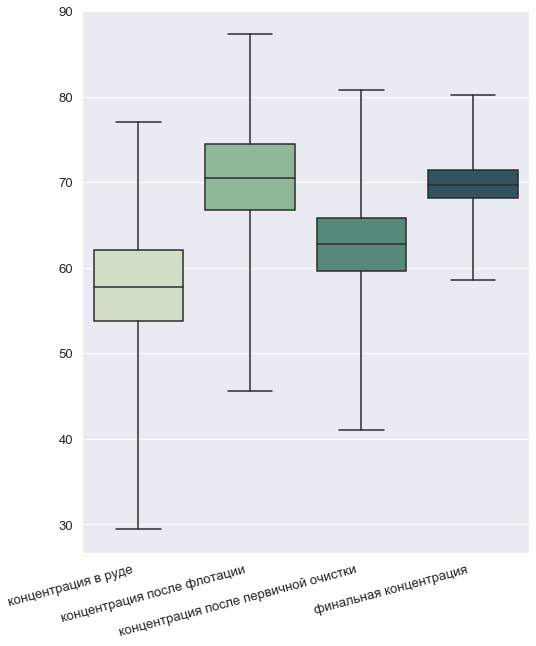

In [339]:
gold_recovery_full_cleaned_moustaches = (gold_recovery_full_cleaned
                                         .loc[(gold_recovery_full_cleaned['rougher.input.feed']>29.5)
                                              & (gold_recovery_full_cleaned['rougher.output.concentrate']>45)
                                              & (gold_recovery_full_cleaned['primary_cleaner.output.concentrate']>41)
                                              & (gold_recovery_full_cleaned['final.output.concentrate']>58.5)
                                              ,:])
display(len(gold_recovery_full_cleaned_moustaches)/len(gold_recovery_full_cleaned))
plot_conc(gold_recovery_full_cleaned_moustaches,concentrations,metals_labels)

In [338]:
# DEPRECATED
# for mt_re,mt_lb in zip(metals_re,metals):
#     res= [i for i in metals_features if re.search(mt_re, i)]
#     plot_conc(gold_recovery_full_cleaned_moustaches,mt_re,mt_lb)

In [337]:
# DEPRECATED

# gold_recovery_train_cleaned_moustaches = (gold_recovery_train_cleaned
#                                          .loc[(gold_recovery_train_cleaned['rougher.input.feed_au']>1.3) & 
#                                               (gold_recovery_train_cleaned['rougher.output.concentrate_au']>10)
#                                               & (gold_recovery_train_cleaned['primary_cleaner.output.concentrate_au']>12) &
#                                               (gold_recovery_train_cleaned['final.output.concentrate_au']>15)
#                                               ,:])
# display('Доля оставшихся для обучения данных ' +str(len(gold_recovery_train_cleaned_moustaches)/len(gold_recovery_train_cleaned)))


*DEPRECATED Я не стал "радикально" подрезать данные по усам. Считаю аномалиями только неадекватное уменьшение концентрации золота от этапа к этапу. Удаление данных "сверху" не производилось.*

Значения внутри полного датасета очищены от аномалий. Это повлекло уменьшение исходного датасета почти на 10%

Теперь удаляем соответствующие значения из тестовой и валидационной выборки. Индексироваться будем по датам.

In [343]:
date_indexes_for_cleaning_moustaches = (gold_recovery_full_cleaned
                                         .loc[(gold_recovery_full_cleaned['rougher.input.feed']<=29.5)
                                              | (gold_recovery_full_cleaned['rougher.output.concentrate']<=45)
                                              | (gold_recovery_full_cleaned['primary_cleaner.output.concentrate']<=41)
                                              | (gold_recovery_full_cleaned['final.output.concentrate']<=58.5)
                                              ,:])['date']
date_indexes_for_cleaning_moustaches

19      2016-01-15 19:00:00
20      2016-01-15 20:00:00
21      2016-01-15 21:00:00
22      2016-01-15 22:00:00
23      2016-01-15 23:00:00
                ...        
22523   2018-08-10 10:59:59
22531   2018-08-10 18:59:59
22532   2018-08-10 19:59:59
22533   2018-08-10 20:59:59
22548   2018-08-11 11:59:59
Name: date, Length: 1806, dtype: datetime64[ns]

In [345]:
gold_recovery_train_cleaned_moustaches = (gold_recovery_train_cleaned
                                          .loc[~gold_recovery_train_cleaned['date']                                         
                                               .isin(date_indexes_for_cleaning_moustaches),
                                               :])
display(len(gold_recovery_train_cleaned_moustaches)/len(gold_recovery_train_cleaned))

0.9026717557251909

In [347]:
gold_recovery_test_cleaned_moustaches =  (gold_recovery_test_cleaned
                                          .loc[~gold_recovery_test_cleaned['date']                                         
                                               .isin(date_indexes_for_cleaning_moustaches),
                                               :])
display(len(gold_recovery_test_cleaned_moustaches)/len(gold_recovery_test_cleaned))
gold_recovery_test_cleaned_moustaches

0.9267418032786885

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800903,14.993117,8.080000,1.005021,1398.981323,-500.225586,1399.144897,-499.919739,1400.103027,-500.704376,1399.001709,-499.485138,13.128569,5.636710,489.793640,62.710453,42.022442,12.084103,16.922876,6.153480,16.867517,6.150709,1001.849304,-350.301270,1249.738647,-399.107544,1249.750488,-399.396729,1198.287842,-399.488586,999.472229,-399.530975,949.566162,-398.180817,24.938200,-500.490967,14.947606,-500.013824,20.018166,-450.395996,13.987059,-449.831512,12.023554,-497.795837,8.016657,-501.289154,7.946562,-432.317841,4.872511,-500.037445,26.705889,-499.709412
1,2016-09-01 01:59:59,215.392456,14.987472,8.080000,0.990469,1398.777954,-500.057434,1398.055420,-499.778168,1396.151001,-499.240173,1399.508057,-500.416321,13.036280,5.526065,490.104523,61.961163,41.187904,11.918977,17.002533,5.999043,16.996063,6.002315,998.690796,-350.425690,1248.395508,-399.946014,1249.514404,-399.630798,1200.506470,-399.942444,1000.002136,-399.491516,950.200012,-405.787506,24.923466,-499.813965,14.930873,-500.764465,19.988503,-450.114014,14.092980,-450.059174,12.058140,-498.695770,8.130980,-499.634216,7.958270,-525.839661,4.878850,-500.162384,25.019939,-499.819427
2,2016-09-01 02:59:59,215.259949,12.884933,7.786667,0.996043,1398.493652,-500.868347,1398.860474,-499.764526,1398.075684,-502.151520,1399.497070,-499.715485,13.138412,5.426561,489.617981,66.903809,42.546295,12.091331,16.992519,5.850632,16.982096,5.853594,998.516724,-349.783539,1247.440796,-400.264343,1248.207153,-401.074402,1199.770020,-400.790588,999.925537,-399.237000,950.320496,-400.864349,24.908731,-500.304047,14.996511,-500.993835,20.039690,-450.263153,14.077881,-449.661011,11.962366,-498.767487,8.096892,-500.827423,8.071055,-500.801666,4.905125,-499.828522,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336243,12.006805,7.640000,0.863514,1399.618164,-498.863586,1397.440063,-499.211029,1400.129272,-498.355865,1401.065186,-501.038727,12.400507,5.114758,476.618134,59.865917,41.060196,12.181598,16.532143,5.801935,16.515276,5.803657,1000.276611,-350.172607,1251.322632,-398.655304,1250.493652,-399.746735,1199.398682,-397.50

Очистка произведена успешно

# 3. Модель
## 3.1. Функция для вычисления итоговой sMAPE 

Формулы метрик качества:
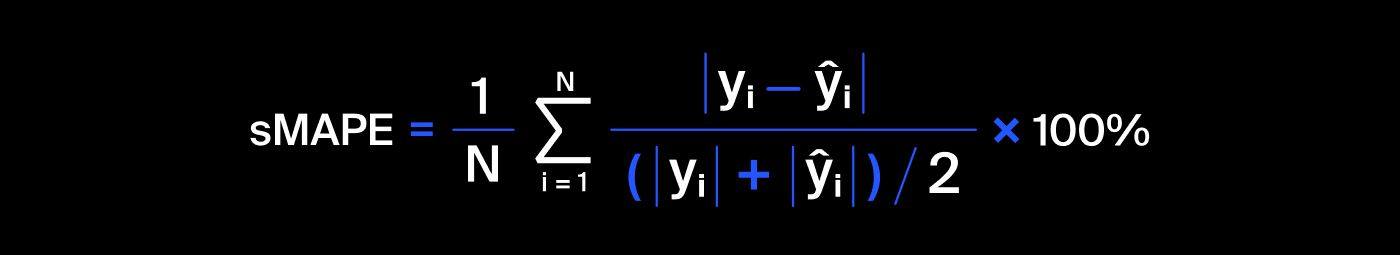

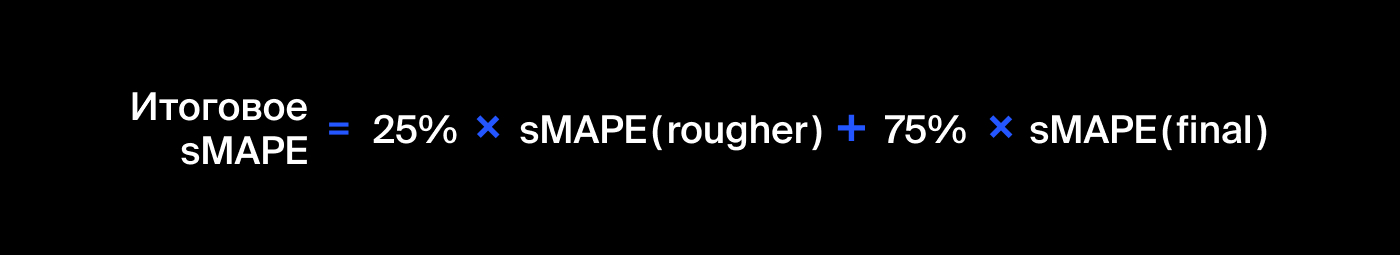

In [359]:
from sklearn.metrics import mean_absolute_error

def sMAPE(y_true,y_pred):      
    output_errors = (np.average(
        (np.abs(y_pred - y_true) / ((np.abs(y_pred)+np.abs(y_true))*0.5))*100, axis=0))
    return output_errors

def final_sMAPE(target,predictions):
    output_errors = (0.25 * sMAPE(target.iloc[:,0],predictions[:,0]) + 
                     0.75 * sMAPE(target.iloc[:,1],predictions[:,1]))
    return output_errors

## 3.2. Обучение разных моделей и оценка их качества кросс-валидацией. Выбер лучшей модели и проверка её качества на тестовой выборке

Рассмотрим проблему обучения модели:
- Нам надо предсказать по очереди две метрики 'rougher.output.recovery','final.output.recovery'
- обе метрики будут предсказываться одной моделью, поиск оптимизированных гиперпараметров для которой и станет нашей главной целью. 
- Обучать будем случайный лес и линейную регрессию.
- Масштабировать признаки мы не будем. На модели линейной регрессии и случайного леса это не требуется

Первый шаг - создать "оценщика" для работы с кросс-валидацией

In [360]:
from sklearn.metrics import make_scorer
sMAPE_scorer = make_scorer(final_sMAPE,greater_is_better =False )
sMAPE_scorer

make_scorer(final_sMAPE, greater_is_better=False)

Подбор оптимальных гиперпараметров мы будем решать в два этапа:
1. RandomizedSearchCV - для предварительного определения области гиперпараметров
2. GridSearchCV - для уточнения ГП в опеределенной области гиперпространства, выбранной вокруг наилучшей оценки на первом шаге.

Использовать для обучения будем датасет с очищенными "усами" из предыдущего шага.
В составе усов оставим только признаки, соответствующие тестовой выборке. Понадобится отделить наборы признаков. 

In [348]:
training_columns = gold_recovery_test_cleaned_moustaches.columns.to_list()
training_columns.remove('date')
training_columns

['primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rough

In [349]:
gold_recovery_train_cleaned_moustaches

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_check
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541214,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107765,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107765
1,2016-01-15 01:00:00,6.029368,9.968945,5.257782,42.701630,69.266197,10.462676,0.927452,16.634514,2.224930,125.629

In [350]:
features = gold_recovery_train_cleaned_moustaches.loc[:,training_columns].reset_index(drop = True)
features

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629234,10.296250,7.25,1.002663,1576.166626,-500.904968,1575.950684,-499.865875,1575.994141,-499.315094,1574.479248,-498.931671,6.161113,2.266033,525.290588,57.278667,35.753384,6.478583,11.971193,6.005766,11.996162,6.012594,1000.286377,-400.065186,1600.754639,-449.953430,1600.479614,-449.830658,1600.527588,-449.953644,1399.227051,-450.869843,1399.719482,-450.118988,25.880539,-499.989655,23.889530,-500.372437,23.970551,-500.085480,22.085714,-499.446899,13.992281,-505.503265,11.950531,-501.331543,10.039246,-500.169983,7.984757,-500.582153,13.998353,-599.787170
2,123.819809,11.316279,7.25,0.991265,1601.556152,-499.997803,1600.386719,-500.607758,1602.003540,-500.870056,1599.541504,-499.827454,6.116455,2.159622,530.026611,57.510651,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719543,-400.074036,1599.337280,-450.008545,1599.672852,-449.954498,1599.849365,-449.954193,1399.180908,-449.937592,1400.316650,-450.527161,26.005245,-499.929626,23.886656,-499.951935,23.913534,-499.442352,23.957716,-499.901978,14.015016,-502.520905,11.912783,-501.133392,10.070913,-500.129120,8.013877,-500.517578,14.028663,-601.427368
3,122.270187,11.322140,7.25,0.996739,1599.968750,-500.951782,1600.659180,-499.677094,1600.304199,-500.727997,1600.449463,-500.052582,6.043309,2.037807,542.590393,57.792732,36.862240,6.118189,11.630094,6.203177,11.692450,6.196578,999.814758,-400.200165,1600.059448,-450.619934,1600.012817,-449.910492,1597.725220,-450.130127,1400.943115,-450.030151,1400.234741,-449.790833,25.942507,-499.176758,23.955517,-499.848785,23.

In [351]:
target = gold_recovery_train_cleaned_moustaches[['rougher.output.recovery','final.output.recovery']].reset_index(drop = True)
target

,rougher.output.recovery,final.output.recovery
0,87.107765,70.541214
1,86.843262,69.266197
2,86.842308,68.116447
3,87.226433,68.347542
4,86.688797,66.927017
...,...,...
12766,89.574379,73.755150
12767,87.724007,69.049294
12768,88.890579,67.002190
12769,89.858124,65.523247


Признаки подготовлены. Импортируем библиотеки моделей линейной регрессии, случайного леса.

In [355]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [363]:
lreg = LinearRegression()
scores = cross_val_score(lreg, features,target, cv=5,scoring = sMAPE_scorer)
scores

array([-11.51757216,  -8.99187267,  -9.47836411,  -7.48245704,
       -10.99112511])

In [383]:
abs(scores.mean())

9.692278218269347

In [365]:
lreg.fit(features, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [366]:
rfr = RandomForestRegressor(random_state= 12345)

distributions = dict(n_estimators = range(1, 201, 40),                
                     max_depth= range(1, 30, 2),                
                     min_samples_leaf = range(1, 10, 3))

In [367]:
rscv = RandomizedSearchCV(estimator = rfr, 
                          param_distributions = distributions,
                          scoring = sMAPE_scorer,
                          n_iter=10,
                          cv =3,
                          n_jobs=8,
                          random_state=12345)

In [368]:
%%time
search = rscv.fit(features, target)

Wall time: 5min 11s


In [373]:
search.cv_results_

{'mean_fit_time': array([  0.24135296, 107.90037219, 101.46923343,  99.3536551 ,
         43.20771122, 166.54990474,  23.86756277,  68.96814895,
         67.76563223,  45.50373379]),
 'std_fit_time': array([0.02484647, 4.90165433, 7.18043011, 5.22817365, 1.98124844,
        6.53988109, 0.6606362 , 1.86150221, 3.94644973, 1.85252897]),
 'mean_score_time': array([0.01861707, 0.14361588, 0.08809916, 0.13518071, 0.05077243,
        0.09708913, 0.05133788, 0.0508635 , 0.07347059, 0.03322824]),
 'std_score_time': array([0.00169509, 0.06740638, 0.01378003, 0.06735703, 0.00842332,
        0.0144904 , 0.01312992, 0.00495384, 0.04081714, 0.00805556]),
 'param_n_estimators': masked_array(data=[1, 121, 121, 121, 81, 161, 41, 81, 81, 121],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[1, 4, 7, 7, 1, 1, 7, 4, 7, 1],
              mask=[Fal

In [370]:
search.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_esti

In [382]:
abs(search.best_score_)

9.23682996768688

In [372]:
search.best_params_

{'n_estimators': 121, 'min_samples_leaf': 1, 'max_depth': 5}

Вокруг данных гиперпараметров мы будем теперь искать оптимум используя брутальный GridSearchCV. Вообще максимальное значение глубины дерева будет назначено от 3х. 

In [374]:
param_grid_gscv = dict(n_estimators = range(100, 141, 20),                
                     max_depth= range(3, 18, 5),                
                     min_samples_leaf = range(1, 13, 3))

In [375]:
gscv = GridSearchCV(estimator = rfr, 
                    param_grid = param_grid_gscv,
                    scoring = sMAPE_scorer,
                    cv =3,
                    n_jobs=8)

In [376]:
%%time
search_gscv = gscv.fit(features, target)

Wall time: 24min 30s


In [378]:
search_gscv.cv_results_

{'mean_fit_time': array([ 15.30178126,  17.57050832,  24.78200475,  33.29919624,
         37.77437425,  27.04843648,  29.31478596,  30.15708097,
         31.7838885 ,  34.44484361,  23.07108053,  28.55683041,
         31.06520057,  33.23744615,  34.95862182,  25.56934444,
         26.58884939,  29.04288228,  31.23898228,  36.32072965,
         59.58701698,  68.91140151,  73.23373326,  80.5008932 ,
         88.76614594,  62.85217889,  67.96051184,  72.23594387,
         78.61594081,  84.806916  ,  60.81201641,  68.59890421,
         72.20517357,  74.50226951,  81.73494927,  58.3710506 ,
         60.24232697,  67.39569974,  71.15322383,  77.95323594,
         82.32098556,  86.63868443,  98.6298759 , 106.49369597,
        112.14423386,  79.65117987,  82.07389474,  92.3507119 ,
         98.59523884, 107.56973592,  74.02329532,  78.92904226,
         88.79128607,  95.01793782, 101.57500712,  69.20596496,
         78.0244685 ,  92.31570292,  92.52577448,  77.83217716]),
 'std_fit_time': arra

In [379]:
search_gscv.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
           

In [381]:
abs(search_gscv.best_score_)

9.045432014160676

In [377]:
search_gscv.best_params_

{'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 110}

Похоже оценка максимальной эффективной глубины дерева оказалась действительно близкой к истине. 

В итоге побеждает модель случайного леса. Ее показатель sMAPE ниже чем у линейной регрессии (9.04 < 9.69 %)

In [384]:
rfr_final = RandomForestRegressor(n_estimators= 110, 
                            min_samples_leaf= 10,
                            max_depth =3,
                            random_state= 12345)
rfr_final.fit(features, target)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

In [385]:
gold_recovery_full_cleaned.columns.to_list()
#['final.output.recovery_check'] 
# = gold_recovery_train.apply(for_,axis=1)

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.s

In [386]:
# хотел устранить пропуски для final.output.recovery
def for_(row): 
    c = row['final.output.concentrate_au']
    f = row['rougher.input.feed_au'] # не нашел атрибута-аналога для secondary_cleaner
    t = row['final.output.tail_au']
    return Recovery(c,f,t)

In [387]:
test =gold_recovery_test_cleaned.set_index('date').join(
    gold_recovery_full.set_index('date')[['rougher.output.recovery','final.output.recovery']],     
    how = 'left')
test_cleaned = test.loc[test['rougher.output.recovery'].notna()
                               & test['final.output.recovery'].notna(),:]
test_cleaned

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800903,14.993117,8.080000,1.005021,1398.981323,-500.225586,1399.144897,-499.919739,1400.103027,-500.704376,1399.001709,-499.485138,13.128569,5.636710,489.793640,62.710453,42.022442,12.084103,16.922876,6.153480,16.867517,6.150709,1001.849304,-350.301270,1249.738647,-399.107544,1249.750488,-399.396729,1198.287842,-399.488586,999.472229,-399.530975,949.566162,-398.180817,24.938200,-500.490967,14.947606,-500.013824,20.018166,-450.395996,13.987059,-449.831512,12.023554,-497.795837,8.016657,-501.289154,7.946562,-432.317841,4.872511,-500.037445,26.705889,-499.709412,89.993421,70.273583
2016-09-01 01:59:59,215.392456,14.987472,8.080000,0.990469,1398.777954,-500.057434,1398.055420,-499.778168,1396.151001,-499.240173,1399.508057,-500.416321,13.036280,5.526065,490.104523,61.961163,41.187904,11.918977,17.002533,5.999043,16.996063,6.002315,998.690796,-350.425690,1248.395508,-399.946014,1249.514404,-399.630798,1200.506470,-399.942444,1000.002136,-399.491516,950.200012,-405.787506,24.923466,-499.813965,14.930873,-500.764465,19.988503,-450.114014,14.092980,-450.059174,12.058140,-498.695770,8.130980,-499.634216,7.958270,-525.839661,4.878850,-500.162384,25.019939,-499.819427,88.089657,68.910432
2016-09-01 02:59:59,215.259949,12.884933,7.786667,0.996043,1398.493652,-500.868347,1398.860474,-499.764526,1398.075684,-502.151520,1399.497070,-499.715485,13.138412,5.426561,489.617981,66.903809,42.546295,12.091331,16.992519,5.850632,16.982096,5.853594,998.516724,-349.783539,1247.440796,-400.264343,1248.207153,-401.074402,1199.770020,-400.790588,999.925537,-399.237000,950.320496,-400.864349,24.908731,-500.304047,14.996511,-500.993835,20.039690,-450.263153,14.077881,-449.661011,11.962366,-498.767487,8.096892,-500.827423,8.071055,-500.801666,4.905125,-499.828522,24.994862,-500.622559,88.412756,68.143213
2016-09-01 03:59:59,215.336243,12.006805,7.640000,0.863514,1399.618164,-498.863586,1397.440063,-499.211029,1400.129272,-498.355865,1401.065186,-501.038727,12.400507,5.114758,476.618134,59.8659

In [388]:
test_features = test_cleaned.drop(columns=['rougher.output.recovery','final.output.recovery'])
test_target = test_cleaned[['rougher.output.recovery','final.output.recovery']]

test_features

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800903,14.993117,8.080000,1.005021,1398.981323,-500.225586,1399.144897,-499.919739,1400.103027,-500.704376,1399.001709,-499.485138,13.128569,5.636710,489.793640,62.710453,42.022442,12.084103,16.922876,6.153480,16.867517,6.150709,1001.849304,-350.301270,1249.738647,-399.107544,1249.750488,-399.396729,1198.287842,-399.488586,999.472229,-399.530975,949.566162,-398.180817,24.938200,-500.490967,14.947606,-500.013824,20.018166,-450.395996,13.987059,-449.831512,12.023554,-497.795837,8.016657,-501.289154,7.946562,-432.317841,4.872511,-500.037445,26.705889,-499.709412
2016-09-01 01:59:59,215.392456,14.987472,8.080000,0.990469,1398.777954,-500.057434,1398.055420,-499.778168,1396.151001,-499.240173,1399.508057,-500.416321,13.036280,5.526065,490.104523,61.961163,41.187904,11.918977,17.002533,5.999043,16.996063,6.002315,998.690796,-350.425690,1248.395508,-399.946014,1249.514404,-399.630798,1200.506470,-399.942444,1000.002136,-399.491516,950.200012,-405.787506,24.923466,-499.813965,14.930873,-500.764465,19.988503,-450.114014,14.092980,-450.059174,12.058140,-498.695770,8.130980,-499.634216,7.958270,-525.839661,4.878850,-500.162384,25.019939,-499.819427
2016-09-01 02:59:59,215.259949,12.884933,7.786667,0.996043,1398.493652,-500.868347,1398.860474,-499.764526,1398.075684,-502.151520,1399.497070,-499.715485,13.138412,5.426561,489.617981,66.903809,42.546295,12.091331,16.992519,5.850632,16.982096,5.853594,998.516724,-349.783539,1247.440796,-400.264343,1248.207153,-401.074402,1199.770020,-400.790588,999.925537,-399.237000,950.320496,-400.864349,24.908731,-500.304047,14.996511,-500.993835,20.039690,-450.263153,14.077881,-449.661011,11.962366,-498.767487,8.096892,-500.827423,8.071055,-500.801666,4.905125,-499.828522,24.994862,-500.622559
2016-09-01 03:59:59,215.336243,12.006805,7.640000,0.863514,1399.618164,-498.863586,1397.440063,-499.211029,1400.129272,-498.355865,1401.065186,-501.038727,12.400507,5.114758,476.618134,59.865917,41.060196,12.181598,16.532143,5.801935,16.515276,5.803657,1000.276611,-350.172607,1251.322632,-398.655304

In [389]:
test_predictions = rfr_final.predict(test_features)
len(test_predictions)

5290

In [390]:
test_target = test_target.reset_index(drop = True)
test_target.isna().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [ ]:
final_sMAPE(test_target,test_predictions)

Получена погрешность на тестовой выборке для регрессионной модели случайного леса с "победившим" набором гиперпараметров обучения равная 8,99%.

In [400]:
from sklearn.dummy import DummyRegressor

Лучшая модель выбрана. и проверена на тестовой выборке. Проверим ее на адекватность сравнив с Dummy моделью.

In [401]:
# “median”, “quantile”
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, target)
final_sMAPE(test_target,dummy_regr.predict(test_features))

9.72007696465146

In [402]:
dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(features, target)
final_sMAPE(test_target,dummy_regr.predict(test_features))

9.436404482495975

In [414]:
dummy_regr = DummyRegressor(strategy='quantile',quantile =0.61)
dummy_regr.fit(features, target)
final_sMAPE(test_target,dummy_regr.predict(test_features))

8.905006700907595

Кажется я нашел лучшую модель!)) И даже без той кросс валидации, которую делал! Выкурим мануал и прокачаем скилл. 
Будем поискать что-то поинтереснее...

In [415]:
from sklearn.ensemble import AdaBoostRegressor

Насколько я понял из описания принципа работы, алгоритм подбирает веса признаков, адаптируя их к наиболее проблемным предсказаниям. И, поскольку это ансамбль - оценщиков также может быть много. 

Сперва просто проба пера!

In [450]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
estimation =[]
for train_index, test_index in kf.split(gold_recovery_train_cleaned_moustaches):    
    target_ada = gold_recovery_train_cleaned_moustaches[['rougher.output.recovery','final.output.recovery']].reset_index(drop = True)
    features_ada = gold_recovery_train_cleaned_moustaches.loc[:,training_columns].reset_index(drop = True)
    a_b_regr_0 = AdaBoostRegressor(random_state=0, n_estimators=100)
    a_b_regr_1 = AdaBoostRegressor(random_state=0, n_estimators=100)

    X_train, X_test = features_ada.iloc[train_index], features_ada.iloc[test_index]
    y_train, y_test = target_ada.iloc[train_index], target_ada.iloc[test_index]
    a_b_regr_0.fit(features, target.iloc[:,0])
    a_b_regr_1.fit(features, target.iloc[:,1])
    one = a_b_regr_0.predict(test_features)
    two = a_b_regr_1.predict(test_features)
    combined = np.array([[i0,i1] for i0,i1 in zip(one,two)])
    estimation.append(final_sMAPE(test_target,combined))
np.array(estimation).mean()

9.245639117854038

Выглядит так, что линейная модель в целом даст не слишком высококачественный результат. Мы не сильно улучшили результаты относительно простой линейной модели. Тогда нам пора повысить ее размерность линейной модели до других порядков полиномов внутри оценщика.

Действуем согласно инструкции с любимого форума: https://www.machinelearningmastery.ru/polynomial-regression-bbe8b9d97491/

In [451]:
from sklearn.preprocessing import PolynomialFeatures

In [505]:
polynomial_features= PolynomialFeatures(degree=2)
features_poly = pd.DataFrame(polynomial_features.fit_transform(features))

In [718]:
features_poly

0           1          2     3         4            5           6  \
0      1.0  127.092003  10.128295  7.25  0.988759  1549.775757 -498.912140   
1      1.0  125.629234  10.296250  7.25  1.002663  1576.166626 -500.904968   
2      1.0  123.819809  11.316279  7.25  0.991265  1601.556152 -499.997803   
3      1.0  122.270187  11.322140  7.25  0.996739  1599.968750 -500.951782   
4      1.0  117.988167  11.913613  7.25  1.009869  1601.339722 -498.975464   
...    ...         ...        ...   ...       ...          ...         ...   
12766  1.0  123.381790   8.028927  6.50  1.304232  1648.421143 -400.382172   
12767  1.0  120.878189   7.962636  6.50  1.302419  1649.820190 -399.930969   
12768  1.0  105.666115   7.955112  6.50  1.315926  1649.166748 -399.888641   
12769  1.0   98.880539   7.984164  6.50  1.241969  1646.547729 -398.977081   
12770  1.0   95.248428   8.078957  6.50  1.283045  1648.759888 -399.862061   

                 7           8            9          10           11  \
0      1551.434204 -516.403442  1549.873901 -498.666595  1554.367432   
1      1575.950684 -499.865875  1575.994141 -499.315094  1574.479248   
2      1600.386719 -500.607758  1602.003540 -500.870056  1599.541504   
3      1600.659180 -499.677094  1600.304199 -500.727997  1600.449463   
4      1601.437866 -500.323242  1599.581909 -500.888153  1602.649536   
...            ...         ...          ...         ...          ...   
12766  1648.742065 -400.359650  1648.578247 -399.363617  1648.833984   
12767  1649.357544 -399.721222  1648.656250 -401.195831  1649.725098   
12768  1649.196899 -399.677582  1647.896973 -399.988281  1649.772705   
12769  1648.212280 -400.383270  1648.917358 -399.521332  1651.498535   
12770  1650.135376 -399.957306  1648.831909 -400.586121  1649.464600   

               12        13        14          15          16         17  \
0     -493.428131  6.100378  2.284912  523.546326   55.486599  36.808594   
1     -498.931671  6.161113  2.266033  525.290588   57.278667  35.753384   
2     -499.827454  6.116455  2.159622  530.026611   57.510651  35.971630   
3     -500.052582  6.043309  2.037807  542.590393   57.792732  36.862240   
4     -500.593018  6.060915  1.786875  540.531921   56.047188  34.347664   
...           ...       ...       ...         ...         ...        ...   
12766 -399.669220  6.091855  4.617558  560.889099   85.718300  37.369774   
12767 -400.636292  6.121323  4.144989  559.031799  119.499245  38.591553   
12768 -399.831909  5.970515  4.020002  555.682861  122.262688  40.074024   
12769 -399.745331  6.048130  3.902537  544.731689  123.742432  39.713905   
12770 -400.673309  6.158718  3.875727  555.820190   94.544357  39.135120   

             18         19        20         21        22           23  \
0      6.486150  11.986616  6.007990  11.836743  6.005818   999.706909   
1      6.478583  11.971193  6.005766  11.996162  6.012594  1000.286377   
2      6.362222  11.920603  6.197377  11.920305  6.204633   999.719543   
3      6.118189  11.630094  6.203177  11.692450  6.196578   999.814758   
4      5.663707  10.957754  6.198826  10.960521  6.194897   999.678711   
...         ...        ...       ...        ...       ...          ...   
12766  5.335862   7.762770  9.158608   7.766744  9.156069  1199.245972   
12767  4.838619   7.356687  9.304952   7.095508  9.297924  1196.569214   
12768  4.525061   6.586020  9.299606   6.584130  9.300133  1204.866699   
12769  4.362782   6.210119  9.297709   6.209517  9.297194  1201.904175   
12770  4.365491   6.146982  9.308612   6.168939  9.309852  1196.238159   

               24           25          26           27          28  \
0     -404.066986  1603.011353 -434.715027  1602.375000 -442.204468   
1     -400.065186  1600.754639 -449.953430  1600.479614 -449.830658   
2     -400.074036  1599.337280 -450.008545  1599.672852 -449.954498   
3     -400.200165  1600.059448 -450.619934  1600.012817 -449.910492   
4     -399.752716  1600.208862 -449.599609  1600.3

In [719]:
features

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,125.629234,10.296250,7.25,1.002663,1576.166626,-500.904968,1575.950684,-499.865875,1575.994141,-499.315094,1574.479248,-498.931671,6.161113,2.266033,525.290588,57.278667,35.753384,6.478583,11.971193,6.005766,11.996162,6.012594,1000.286377,-400.065186,1600.754639,-449.953430,1600.479614,-449.830658,1600.527588,-449.953644,1399.227051,-450.869843,1399.719482,-450.118988,25.880539,-499.989655,23.889530,-500.372437,23.970551,-500.085480,22.085714,-499.446899,13.992281,-505.503265,11.950531,-501.331543,10.039246,-500.169983,7.984757,-500.582153,13.998353,-599.787170
2,123.819809,11.316279,7.25,0.991265,1601.556152,-499.997803,1600.386719,-500.607758,1602.003540,-500.870056,1599.541504,-499.827454,6.116455,2.159622,530.026611,57.510651,35.971630,6.362222,11.920603,6.197377,11.920305,6.204633,999.719543,-400.074036,1599.337280,-450.008545,1599.672852,-449.954498,1599.849365,-449.954193,1399.180908,-449.937592,1400.316650,-450.527161,26.005245,-499.929626,23.886656,-499.951935,23.913534,-499.442352,23.957716,-499.901978,14.015016,-502.520905,11.912783,-501.133392,10.070913,-500.129120,8.013877,-500.517578,14.028663,-601.427368
3,122.270187,11.322140,7.25,0.996739,1599.968750,-500.951782,1600.659180,-499.677094,1600.304199,-500.727997,1600.449463,-500.052582,6.043309,2.037807,542.590393,57.792732,36.862240,6.118189,11.630094,6.203177,11.692450,6.196578,999.814758,-400.200165,1600.059448,-450.619934,1600.012817,-449.910492,1597.725220,-450.130127,1400.943115,-450.030151,1400.234741,-449.790833,25.942507,-499.176758,23.955517,-499.848785,23.

In [720]:
lreg_poly = LinearRegression(normalize=True)
scores_poly = cross_val_score(lreg_poly, features_poly,target, cv=5,scoring = sMAPE_scorer)
scores_poly

array([-31.0783062 , -84.57413673, -40.78698349, -22.26517296,
       -27.2512269 ])

In [722]:
abs(scores_poly.mean()) # неадекватное значение. Так и не разобрался почему

41.19116525650024

<font color='blue'>Получилось очень много признаков: вместо 52 стало 1431, поэтому линейная регрессия дала такой плохой результат. </font>


In [721]:
lreg_poly0 = LinearRegression(normalize=True)
lreg_poly0.fit(features,target0)
lreg_poly1 = LinearRegression(normalize=True)
lreg_poly1.fit(features,target1)
one = lreg_poly0.predict(test_features)
two = lreg_poly1.predict(test_features)
combined = np.array([[i0,i1] for i0,i1 in zip(one,two)])
display(sMAPE(test_target.iloc[:,0],one))
display(sMAPE(test_target.iloc[:,1],two))
final_sMAPE(test_target,combined)

8.945127486556643

9.484529319194305

9.349678861034889

Попробуем регрессию по ближайшим соседям. Посмотрим, что это даст.

In [560]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(weights = 'uniform',leaf_size = 3)
neigh.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [567]:
param_neigh_gscv = dict(n_neighbors = range(3, 8, 1))

In [ ]:
gs_neigh_cv = GridSearchCV(estimator = neigh, 
                    param_grid = param_neigh_gscv,
                    scoring = sMAPE_scorer,
                    cv =3,
                    n_jobs=6)

In [578]:
target0 = target.iloc[:,0]
target1 = target.iloc[:,1]

In [ ]:
%%time
neigh0 = KNeighborsRegressor(weights = 'uniform',leaf_size = 3)
neigh0.fit(features,target0)
neigh1 = KNeighborsRegressor(weights = 'uniform',leaf_size = 3)
neigh1.fit(features,target1)

In [584]:
one = neigh0.predict(test_features)
two = neigh1.predict(test_features)
combined = np.array([[i0,i1] for i0,i1 in zip(one,two)])
display(sMAPE(test_target.iloc[:,0],one))
display(sMAPE(test_target.iloc[:,1],two))
final_sMAPE(test_target,combined)

10.852439279904845

11.681481020749686

11.474220585538475

In [621]:
gs_neigh_cv_search = gs_neigh_cv.fit(features, target)

In [564]:
gs_neigh_cv_search.best_params_

{'n_neighbors': 7}

In [565]:
gs_neigh_cv_search.best_score_

-13.346039533615112

### Выводы
- Наилучшее качество предсказаний обеспечила модель регрессии случайного леса. Я не исключаю, что есть более эффективные модели,гиперпараметры использованных моделей для данной задачи
- По оценке кросс валидации не получилось найти более эффективную модель, чем лес. Но дамми модель победила данный лес. 
- Для более качественных предсказаний стоит выяснить, какие единицы измерения использует модель для параметров.



По данному проекту возникло много вопросов, которые лучше бы решать в живом общении с "заказчиком". Например следовало бы обсудить утечки целевого признака: последующие этапы очистки сырья не должны влиять на показатели предыдущих. Я пока не очень понимаю, как это осуществить имплементировав в оптимизацию модели еще метрику sMAPE. Ведь на нее в разной мере влияет качество модели оценки результатов флотации и финальной стадии. 
